## Dependencies

In [1]:
import math
import random

import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from sklearn_extra.cluster import KMedoids

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import gurobipy as gp
from gurobipy import GRB

import pickle
from itertools import permutations, combinations, chain





# Utilities

In [3]:
# This file contains functions for analyzing elections and clustering ballots. 
#This is copied from mggg to give me easy access to knowing what their functions are/do

# An elections is represented as a dictionary matching ballots to weights.
#   For example `{(1,3,4):5, (1): 7}` is the election where $5$ people cast the ballot $(1,3,4)$
#   while $7$ people cast the bullet vote for candidate $1$.  
#   The candidates are always named $1,2,...n$.

# A clustering of an election means a partition its ballots.  
#   Each cluster (each piece of the partition) is itself an election, 
#   so the clustering is represented as a list of elections.  

def remove_zeros(ballot):
    """
    Helper function for parse.
    """
    to_return = []
    for vote in ballot:
        if vote != 0:
            to_return.append(vote)
    return tuple(to_return)

def parse(filename):
    """
    Returns a tuple (election, names, location) obtained from parsing the format in which Scottish election data is stored.
        
    The returned election is a dictionary matching ballots to weights.  For example {(1,3,4):5, (1): 7} is the election where 5 people cast the ballot (1,3,4) while 7 people cast the bullet vote for candidate 1.
    
    The candidates are coded 1,2,...n in the ballots of the returned election.  The returned names tells the corresponding candidate names. 

    Args:
        filename : name of file (.csv or .blt) containing the Scottish election data.
    
    Returns:
        tuple: election, names, location.
    """

    election = {}
    names = []
    numbers = True
    with open(filename, "r") as file:
        for line in file:
            s = line.rstrip("\n").rstrip()
            if numbers:
                ballot = [int(vote) for vote in s.split(" ")]
                num_votes = ballot[0]
                if num_votes == 0:
                    numbers = False
                else:
                    election[remove_zeros(ballot[1:])] = num_votes
            elif "(" not in s:
                return election, names, s.strip("\"")
            else:
                name_parts = s.strip("\"").split(" ")
                first_name = " ".join(name_parts[:-2])
                last_name = name_parts[-2]
                party = name_parts[-1].strip("(").strip(")")
                names.append((first_name, last_name, party))
    raise Exception(f"Error parsing file '{filename}'.")

def print_color(text,n): # print the text in the color associated to the integer index n.
    """
    Helper function for Summarize_election
    """
    black_code = "\033[00m"
    color_code = f"\033[{91+n}m"
    print(color_code,text,black_code)    

def Summarize_election(election, clusters=None, size=10):
    """
    Prints basic data about the given election including num candidates, num ballots, num distinct ballots, average ballot length, and the 10 (or any number) most often cast ballots.

    If a clustering is also given, then it also prints this data saparately for each cluster and color codes by cluster the list of most commonly cast ballots.  

    Args:
        election : a dictionary matching ballots to weights (# times cast).
        clusters : a clustering (list of elections) that partition the ballots of the election. 
        size : The desired length of the list of the most commonly cast ballots.
    """
    all_ballots = [ballot for ballot in election.keys() if election[ballot]>0]
    num_ballots = len(all_ballots)
    candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
    num_cands = len(candidates)
    num_voters = sum([election[ballot] for ballot in all_ballots])
    mu = sum([len(ballot)*election[ballot] for ballot in election.keys()])/sum(election.values())
    print(f"This election has: {num_cands} candidates, {num_voters} ballots, {num_ballots} distinct ballots, {round(mu,2)} avg ballot length.")

    if not clusters==None:
        for cluster_num in range(len(clusters)):
            cluster = clusters[cluster_num]
            all_ballots_c = [ballot for ballot in cluster.keys() if cluster[ballot]>0]
            num_ballots_c = len(all_ballots_c)
            num_voters_c = sum([cluster[ballot] for ballot in all_ballots_c])
            mu_c = sum([len(ballot)*cluster[ballot] for ballot in cluster.keys()])/sum(cluster.values())           
            print_color(f"CLUSTER {cluster_num+1}: {num_voters_c} ballots, {num_ballots_c} distinct ballots, {round(mu_c,2)} avg ballot length.",cluster_num)
            
    print("Top ballots:")
    ls = sorted(set(election.values()))
    count = 0
    broken = False
    while not broken:
        val = ls.pop()        
        bs = [ballot for ballot in all_ballots if election[ballot]==val]
        for ballot in bs:
            if clusters == None:
                color = -91 # black
            else:
                assignments = [n for n in range(len(clusters)) if ballot in clusters[n].keys() and clusters[n][ballot]>0]
                if len(assignments)==1:
                    color = assignments[0]
                else:
                    color = -84 # black outliner to indicate multiple clusters
            print_color(f"\t {val} votes for {ballot}.", color)
            count +=1
            if count>size:
                broken = True
                break

def Plot_ballot_lengths(clusters, num_cands = 'Auto', filename=None):
    """
    Plots a histogram of the ballot lengths for the given election or clustering.

    If a clustering is given instead of an election, it superimposes histrograms for each cluster.  

    Args:
        clusters : either an election (a dictionary matching ballots to weights) or a clustering (a list of elections).
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it.
        filename : to save the plot.
    """
    if type(clusters)==dict:
        clusters = [clusters]
    k = len(clusters)
    if num_cands == 'Auto':        
        all_ballots = [x for cluster in clusters for x in cluster] 
        num_cands = max([item for ranking in all_ballots for item in ranking])

    X = np.arange(num_cands)
    width = .7/k
    palat = ['grey','purple','tomato','orange','b','c','g', 'r', 'm', 'y', 'k']
    fig, ax = plt.subplots()

    for clust in range(k):
        Y = np.zeros(num_cands)
        for ballot, weight in clusters[clust].items():
            Y[len(ballot)-1]+=weight
        Y = Y/sum(clusters[clust].values())
        ax.bar(X+clust*width,Y, width=width, label = f"Cluster {clust+1}", color = palat[clust])
    ax.set_title('Ballot lengths')
    ax.set_xlabel('ballot length')
    plt.xticks(X+(width*(k-1)/2) ,X+1)
    plt.legend()
    if filename == None:
        plt.show()
    else:
        plt.savefig(filename)


def Borda_vector(ballot_or_election,num_cands='Auto', borda_style='bord'):
    # """
    # Returns the Borda vector of the given ballot or election.  The "Borda vector of an election" means the (weighted) sum of the Borda vectors of its ballots.

    # Set borda_style = 'standard' for the standard convention that, in an election with n candidates, awards n-k points to the candidate in position k, and awards zero points for missing candidates.
    
    # Set borda_style = 'bord' for  to use the "Conservative" convenction that awards n-k-1 points to the candidate in position k, and awards zero points for missing candidates.
    
    # Set borda_style = 'full_points' for  to use the "Averaged" convenction that every ballot awards exactly 1+2+\cdots+n Borda points; this is achieved for a short ballot by dividing the unawarded points equally among the missing candidates.

        
    # Args:
    #     ballot_or_election : a single ballot (tuple) or an election (dictionary matching ballots to weights)
    #     num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it, but only if an election is given, since a single ballot isn't enough to determine num_cands.
    #     borda_style : choice of {'standard', 'bord', 'full_points'}
     
    # Returns:
    #     the Borda vector (np.array) of the given ballot or election.                
    # """
    L = 1 if borda_style=='bord' else 0
    # Borda vector of a ballot
    if type(ballot_or_election) == tuple:
        if num_cands=='Auto':
            raise Exception("A single ballot is not enough to determine the number of candidates.")
        ballot = ballot_or_election
        to_return = [0 for _ in range(num_cands)]
        for count in range(len(ballot)):
            candidate = ballot[count]
            to_return[candidate-1] = num_cands-count - L
        if borda_style=='full_points':
            missing_cands = set(range(1,num_cands+1))-set(ballot)
            for candidate in missing_cands:
                to_return[candidate-1] += (len(missing_cands)+1)/2
            
    # Borda vector of an election
    else:
        election = ballot_or_election
        if num_cands == 'Auto':
            num_cands = max([item for ranking in election.keys() for item in ranking])

        to_return = [0 for _ in range(num_cands)]
        for ballot, ballot_weight in election.items():
            for count in range(len(ballot)):
                candidate = ballot[count]
                to_return[candidate-1] += ballot_weight*(num_cands-count-L)
            if borda_style=='full_points':
                missing_cands = set(range(1,num_cands+1))-set(ballot)
                for candidate in missing_cands:
                    to_return[candidate-1] += ballot_weight*(len(missing_cands)+1)/2
    
    return np.array(to_return)

def Borda_dist(CA, CB, num_cands = 'Auto', borda_style='bord', order = 1):
    # """
    # Returns the L^p distance between the Borda vectors of the given pair of ballots or elections,
    #     where p is called the order (for example, order=2 is the Euclidean distance).

    # Set borda_style = 'standard' for the standard convention that, in an election with n candidates, awards n-k points to the candidate in position k, and awards zero points for missing candidates.
    
    # Set borda_style = 'bord' for  to use the "Conservative" convenction that awards n-k+1 points to the candidate in position k, and awards zero points for missing candidates.
    
    # Set borda_style = 'full_points' for  to use the "Averaged" convenction that every ballot awards exactly 1+2+\cdots+n Borda points; this is achieved for a short ballot by dividing the unawarded points equally among the missing candidates.
    
    # Args:
    #     CA, CB : a pair of ballots (tuples) or elections (dictionaries matching ballots to weights).
    #     num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it,
    #                 but only if an election is given, since a ballot pair isn't enough to determine num_cands.
    #     borda_style : choice of {'standard', 'bord', 'full_points'}
    #     order : the choice of p with resepct to which the L^p distance is computed.
    
    # Returns:
    #     the L^p distance between the Borda vectors.                
    # """
    if num_cands == 'Auto':
        if type(CA) == tuple:
            raise Exception("A single pair of ballot is not enough to determine the number of candidates.")
        else:
            all_ballots = list(CA.keys())+list(CB.keys())
            num_cands = max([item for ranking in all_ballots for item in ranking])
            
    VA = Borda_vector(CA, num_cands=num_cands, borda_style=borda_style)
    VB = Borda_vector(CB, num_cands=num_cands, borda_style=borda_style)
    return np.linalg.norm(VA - VB,ord=order)

def Candidate_matrix(election, num_cands = 'Auto'):
    """
    Helper function for Plot_clusters   
    """
    # Creates a matrix M such that M[i-1][c-1] is the number of ith place votes received by candidate c.
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    
    to_return = np.zeros([num_cands,num_cands])
    for ballot in election.keys():
        ballot_weight = election[ballot]
        for ballot_position in range(len(ballot)):
            candidate = ballot[ballot_position]
            to_return[ballot_position][candidate-1] += ballot_weight
    return to_return

def Plot_clusters(clusters, method = 'Borda', borda_style='bord', num_cands = 'Auto', order = 'Auto', filename=None):
    """
    Displays a bar plot that helps visualize the given election or clustering.

    Args:
        election: either an election (a dictionary matching ballots to weights) or a clustering (a list of elections).
        method: either 'Borda' for a Borda plot, or 'Mentions' for a stacked mentions plot.
        borda_style: choice of {'bord', 'standard', 'full_points'}, which is passed to Borda_vector.
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it.
        order : Set order='Auto' to order the candidates by deceasing Borda scores in the first cluster.  Set say order=[3,2,4,1] to order the candidates according to the given list. 
        filename : to save the plot.     
    """
    if type(clusters)==dict:
        clusters = [clusters]
    k = len(clusters)
    if num_cands == 'Auto':        
        all_ballots = [x for cluster in clusters for x in cluster] 
        num_cands = max([item for ranking in all_ballots for item in ranking])
    if method=='Borda':
        Scores = [Borda_vector(clusters[n], num_cands=num_cands, borda_style=borda_style) for n in range(k)]
    else:
        Scores = [Candidate_matrix(clusters[n], num_cands = num_cands) for n in range(k)]

    if type(order)==list:
        perm = [x-1 for x in order]
    if order=='Auto': # Order candidates by Borda scores of first cluster
        perm = np.flip(np.argsort(np.array(Borda_vector(clusters[0], num_cands=num_cands))))
    if type(order)==list or order=='Auto':
        Ordered_candidates = []
        if method == 'Borda':
            Ordered_scores = [np.zeros(num_cands) for _ in range(k)]
        else:
            Ordered_scores = [np.zeros([num_cands,num_cands]) for _ in range(k)]
        for cand in range(num_cands):
            Ordered_candidates.append(perm[cand]+1)
            for clust in range(k):
                if method == 'Borda':
                    Ordered_scores[clust][cand] = Scores[clust][perm[cand]]
                else:
                    for ballot_position in range(num_cands):
                        Ordered_scores[clust][ballot_position,cand] = Scores[clust][ballot_position,perm[cand]]
    else:
        Ordered_candidates = list(range(1,num_cands+1))
        Ordered_scores = Scores

    palat = ['grey','purple','tomato','orange','b','c','g', 'r', 'm', 'y', 'k']
    r = np.arange(num_cands)
    width = 0.7/k
    bottoms = [np.zeros(num_cands) for _ in range(k)]
    fig, ax = plt.subplots()
    
    for clust in range(k):
        if method == 'Borda':
            pA = ax.bar(r + clust*width, Ordered_scores[clust], label=f"Cluster {clust+1}", color = palat[clust],
                width = width, edgecolor = 'black')
        else:
            for shade in range(1,num_cands+1):
                Shade_scores = Ordered_scores[clust][shade-1]
                label = f"Cluster {clust+1}" if shade==1 else None
                pA = ax.bar(r+clust*width, Shade_scores, width=width, bottom = bottoms[clust], 
                            color = (palat[clust],1/shade), label=label)
                bottoms[clust] += Shade_scores

    if method == 'Borda':
        ax.set_title('Borda Scores of Candidates by Cluster')
    else:
        ax.set_title('Candidate Mentions Stacked by Ballot Position')
    ax.set_xlabel('Candidate')
    plt.xticks(r + (width*(k-1))/2,Ordered_candidates)
    plt.legend()
    if filename == None:
        plt.show()
    else:
        plt.savefig(filename)

def HH_proxy(ballot,num_cands):
    """
    Returns the head-to-head proxy vector of the given ballot.
        
    This is a vector with one entry for each pair of candidates ordered in the natural way; namely {(1,2),(1,3),...,(1,n),(2,3),...}.  The entries lie in {-1/2,0,1/2} depending on whether the lower-indexed candidate {looses, ties, wins} the head-to-head comparison. 

    Args:
        ballot: a single ballot (tuple)
    
    Returns:
        The head-to-head proxy vector (np.array)
    """
    M = np.zeros([num_cands,num_cands])
    for x,y in combinations(ballot,2):
        M[x-1,y-1] = 1/2
        M[y-1,x-1] = -1/2
    for x in ballot:
        for y in set(range(1,num_cands+1)) - set(ballot): # candidates missing from the ballot
            M[x-1,y-1] = 1/2
            M[y-1,x-1] = -1/2
    to_return = []
    for x,y in combinations(range(num_cands),2):
        to_return.append(M[x,y])
    return np.array(to_return)

def HH_dist(ballot1, ballot2, num_cands, order = 1):
    """
    Returns the L^p distance between the head-to-head proxy vectors of the given pair of ballots, where p is called the order.

    Args:
        ballot1 : ballot (tuple)
        ballot2 : ballot (tuple)
        num_cands : the number of candidates
        order : the choice of p with respect to which the L^p distance is computed
    
    Returns:
        The L^p distance between the proxy vectors.   
    """
    H1 = HH_proxy(ballot1, num_cands=num_cands)
    H2 = HH_proxy(ballot2, num_cands=num_cands)
    return np.linalg.norm(H1-H2,ord=order)

def kmeans(election, k=2, proxy='Borda', borda_style='bord', n_init=200, return_centroids=False):
    """
    Returns the clustering obtained by applying the k-means algorithm to the proxies of the ballots.

    Args:
        election : dictionary matching ballots with weights.
        k : the number of clusters desired.
        proxy : choice of {'Borda', 'HH'} for Borda or head-to-head proxy vectors.
        borda_style : choice of {'bord', 'standard', 'full_points'}, which is passed to Borda_vector (only if proxy == 'Borda') 
        n_init : the algorithm runs n_init independent times with different starting centers each time, and outputs the clustering that has the best score from all the runs.
        return_centroids : set to True if you want it to also return the centroids of the returned clustering.

    Returns:
        if return_centroids == False: returns a clustering (list of elections).
        if return_centroids == True: returns a tuple (clustering, centroids).
    """
    all_ballots = list(election.keys())
    num_ballots = len(all_ballots)
    candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
    num_cands = len(candidates)
    sample_weight = np.array([election[ballot] for ballot in all_ballots])
    if proxy=='Borda':
        X = np.array([Borda_vector(ballot, num_cands=num_cands, borda_style=borda_style) 
                      for ballot in all_ballots])
    else:
        X = np.array([HH_proxy(ballot,num_cands=num_cands) for ballot in all_ballots])
    
    model = KMeans(n_clusters=k, n_init=n_init).fit(X,sample_weight=sample_weight)
    labels = model.labels_
    centroids = model.cluster_centers_
    
    C = [dict() for _ in range(k)]
    for count in range(len(all_ballots)):
        ballot = all_ballots[count]
        C[labels[count]][ballot]=election[ballot]
    if return_centroids:
        return C, centroids
    else:
        return C
    
def Manhattan_dist(A,B):
    return sum(np.abs(A-B))

def kmedoids(election, k=2, proxy='Borda', borda_style='bord', verbose = False,
             method = 'pam', share_ties = True, return_medoids=False):
    """
    Returns the clustering obtained by applying the k-medoid algorithm to the proxies of the ballots.

    Args:
        election : dictionary matching ballots with weights.
        k : the number of clusters desired.
        proxy : choice of {'Borda', 'HH'} for Borda or head-to-head proxy vectors.
        borda_style : choice of {'bord', 'standard', 'full_points'}, which is passed to Borda_vector (only if proxy == 'Borda') 
        verbose : set to True if you want it to print the medoids.
        method : choice of {'pam','alternate'}.  The method 'pam' is more accurate, while 'alternate' is faster
        share_ties : set to True if you want the weight of any ballot that's equidistant to mulitple medoids to be shared between the corresponding clusters in the final iteration. This requires overlaid code because sklearn gives ties to the lowest-indexed cluster (which causes repeatability isses).  
        return_medoids : set to True if you want it to also return the medoids of the returned clustering.

    Returns:
        if return_medoids == False: returns a clustering (list of elections).
        if return_medoids == True: returns a tuple (clustering, medoids).
    """
    num_cands = max([item for ranking in election.keys() for item in ranking])

    # create a matrix whose rows are the ballots (repeated as many times as the ballot was cast) 
    # and a dictionary matching each ballot type with its first corresponding row in the matrix
    # and a reverse dictionary to match each row number of the matrix with a ballot
    X = []
    ballot_to_row = dict()
    row_to_ballot = dict()
    counter = 0
    for ballot, weight in election.items():
        ballot_to_row[ballot]=counter
        for _ in range(weight):
            if proxy=='Borda':
                X.append(Borda_vector(ballot, num_cands=num_cands, borda_style=borda_style))
            else:
                X.append(HH_proxy(ballot,num_cands=num_cands))
            row_to_ballot[counter]=ballot
            counter +=1
    
    model = KMedoids(n_clusters=k, metric="manhattan", method = method, init = 'k-medoids++').fit(X)
    labels = model.labels_
    medoids = model.cluster_centers_
    medoid_ballots = [row_to_ballot[index] for index in model.medoid_indices_]

    if verbose:
        print(f"Medoids = {medoid_ballots}.")

    # convert labels into a clustering (list of dictionaries)
    C = [dict() for _ in range(k)]
    if share_ties:
        total_shared_weight = 0
        for ballot, weight in election.items():
            proxy = X[ballot_to_row[ballot]]
            dists = [Manhattan_dist(medoid,proxy) for medoid in medoids]
            clusts = [x for x in range(k) if dists[x]==np.min(dists)] # multi-valued argmin
            if len(clusts)>1:
                total_shared_weight +=weight
            for clust in clusts:
                C[clust][ballot]=weight/len(clusts)
        #if verbose:
        #    print(f"Portion of ballots that tied = {total_shared_weight/sum(election.values())}")

    else:
        for ballot, weight in election.items():
            lab = labels[ballot_to_row[ballot]]
            C[lab][ballot]=weight

    if return_medoids:
        return C, medoid_ballots
    else:
        return C
    
def Random_clusters(election,k=2): # returns a random clustering of the ballots.
    """ 
    Returns the clustering obtained by performing a random partition of the ballots.
    The full weight if each ballot is put into a single randomly selected one of the clusters.

    Args:
        election : dictionary matching ballots with weights.
        k : the number of clusters desired.
    
    Returns:
        a clustering (list of elections).
    """
    C = [dict() for _ in range(k)]
    for ballot in list(election.keys()):
        die = random.randint(0,k-1)
        C[die][ballot] = election[ballot]
    return C

def Clustering_closeness(election,C1,C2, num_cands = 'Auto'):
    """
    Returns the closeness of the given two clusterings, which means the portion of the total ballots for which the two partitions differ (with respect to the best matching of one partition's two clusters with the other's two clusters)
    
    Args:
        election : a dictionary matching ballots to weights.
        C1 : a clustering (list of elections) which must have exactly 2 clusters.
        C2 : a clustering (list of elections) which must have exactly 2 clusters.
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it.

    Returns:
        The closeness of the two clusterings, which equals 0 of they are identical and equals about .5 if they are as unrelated as would be a random pair of clusterings.   
    """
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    matchAA = 0
    matchAB = 0
    for ballot in election.keys():
        W1A = C1[0][ballot] if ballot in C1[0].keys() else 0
        W1B = C1[1][ballot] if ballot in C1[1].keys() else 0
        W2A = C2[0][ballot] if ballot in C2[0].keys() else 0
        W2B = C2[1][ballot] if ballot in C2[1].keys() else 0
        matchAA += np.abs(W1A-W2A) 
        matchAB += np.abs(W1A-W2B)
    return min(matchAA,matchAB)/sum(election.values())

def Cluster_mds_plot(election, clusters, proxy='Borda', borda_style='bord', threshold=10, label_threshold = np.infty,
                     metric = 'Euclidean', plot_centers = True, filename=None):
    """
    Displays an MDS (multi-dimensional scaling) plot for the proxies of all of the ballots in the election that received at least the given threshold number of votes, colored by their cluster assignments.

    Args:
        election : a dictionary matching ballots to weights.
        clusters : a clustering (list of elections that partitions the given election.)
        proxy : choice of {'Borda', 'HH'} for Borda or head-to-head proxy vectors.
        borda_style : choice of {'bord', 'standard', 'full_points'}, which is passed to Borda_vector (only used if proxy == 'Borda') 
        threshold : it ignores all ballots that were cast fewer than the threshold number of times.
        label_threshold : it labels all ballots that were cast at least the label_threshold number of times (set label_threshold=np.infty for no labeling)
        metric : choice of {'Euclidean', 'Manhattan'} for the proxy metric that's approximated.
        plot_centers : set True to plot the centroid of each cluster as a "+" symbol and to display the medoid of each cluster as a thickened circle.
        filename : to save the plot.   
    """

    num_cands = max([item for ranking in election.keys() for item in ranking])

    ballots = []
    proxies = []
    weights = []
    cluster_assignments = []
    is_medoid = []
    is_centroid = []

    for cluster_num in range(len(clusters)):
        cluster = clusters[cluster_num]
        start_index = len(proxies)
        these_proxies = []
        these_weights = []
        for ballot,weight in cluster.items():
            if weight>=threshold:
                if proxy=='Borda':
                    ballot_proxy = Borda_vector(ballot,num_cands=num_cands, borda_style=borda_style)
                else:
                    ballot_proxy = HH_proxy(ballot,num_cands=num_cands)
                ballots.append(ballot)
                proxies.append(ballot_proxy)
                these_proxies.append(ballot_proxy)
                is_centroid.append(False)
                is_medoid.append(False)
                weights.append(weight)
                these_weights.append(weight)
                cluster_assignments.append(cluster_num)
        if plot_centers:
            if metric == 'Euclidean':
                these_similarities = euclidean_distances(these_proxies)
            else:
                these_similarities = manhattan_distances(these_proxies)
            these_weights = np.array(these_weights)
            these_proxies = np.array(these_proxies)
            row_sums = [np.dot(row,these_weights) for row in these_similarities]
            medoid_index = np.argmin(row_sums)
            is_medoid[start_index+medoid_index] = True
            centroid = [np.dot(these_proxies[:,col_num],these_weights) for col_num in range(len(these_proxies[0]))]
            centroid = np.array(centroid)/sum(these_weights)
            proxies.append(centroid)
            ballots.append(())
            weights.append(1)
            cluster_assignments.append(cluster_num)
            is_medoid.append(False)
            is_centroid.append(True)
            
    if metric == 'Euclidean':
        similarities = euclidean_distances(proxies)
    else:
        similarities = manhattan_distances(proxies)

    projections = MDS(n_components=2, dissimilarity='precomputed').fit_transform(similarities)
    X = np.array([p[0] for p in projections])
    Y = np.array([p[1] for p in projections])

    palat = ['grey','purple','tomato','orange','b','c','g', 'r', 'm', 'y']
    colors = [palat[x] for x in cluster_assignments]
    fig, ax = plt.subplots()
    ax.scatter(X,Y, s = weights, c = colors, alpha = .5)
    ax.set_title('MDS Plot')
    ax.grid(False)
    ax.axis('off')
    for count in range(len(proxies)):
        if weights[count]>label_threshold:
            ax.annotate(ballots[count], xy=(X[count], Y[count]))
    if plot_centers:
        # Plot medoids
        X_0 = [X[t] for t in range(len(X)) if is_medoid[t]]
        Y_0 = [Y[t] for t in range(len(Y)) if is_medoid[t]]
        colors_0 = [colors[t] for t in range(len(colors)) if is_medoid[t]]
        weights_0 = [weights[t] for t in range(len(weights)) if is_medoid[t]]
        ax.scatter(X_0,Y_0, s = weights_0, c = colors_0, alpha = .5, edgecolors='k', linewidth=4)

        # Plot centroids
        X_0 = [X[t] for t in range(len(X)) if is_centroid[t]]
        Y_0 = [Y[t] for t in range(len(Y)) if is_centroid[t]]
        ax.scatter(X_0,Y_0, c = 'k', marker='P')

    if filename == None:
        plt.show()
    else:
        plt.savefig(filename)

## Helper functions for Find_slates  
def Matrix_merge(M,i,j): # Merges index i and j of the given matrix.  Assumes i<j.
    """
    Helper function for Find_slates.   
    """
    n = len(M)
    to_return = np.zeros([n-1,n-1])
    for x in range(n-1):
        for y in range(n-1):
            xp = x if x<j else x+1
            yp = y if y<j else y+1
            if (x==i and y==i):
                value = 0
            elif x==i:
                value = M[i,yp]+M[j,yp]
            elif y==i:
                value = M[xp,i]+M[xp,j]
            else:
                value = M[xp,yp]
            to_return[x,y] = value
    return to_return

def List_merge(L,i,j): # Merges entries i and j of the given list.
    """
    Helper function for Find_slates.   
    """
    n = len(L)
    to_return = []
    for x in range(n-1):
        offset = 0 if x<j else 1
        if x<i:
            to_return.append(L[x])
        elif x==i:
            to_return.append(L[i].union(L[j]))
        else:
            to_return.append(L[x+offset])
    return to_return

def Candidate_weight_dict(L): 
    """
    Helper function for Find_slates.   
    """
    # returns a dictionary matching candidate numbers to positions in the partial order.
    DR = dict()
    for count in range(len(L)):
        for candidate in L[count]:
            DR[candidate] = count
    return DR

def Success_count(election, L, num_cands = 'Auto'): 
    """
    Helper function for Find_slates.   
    """
    # returns the portion of ballots in the election that are weakly consistent with L.

    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    DL = Candidate_weight_dict(L)
    Yes_count = 0
    No_count = 0
    for ballot, weight in election.items():
        broke = False
        for a,b in combinations(ballot,2):
            if DL[a]>DL[b]:
                broke = True
                break
        for a in ballot:
            for b in set(range(1,num_cands+1)) - set(ballot): # candidates missing from the ballot
                if DL[a]>DL[b]:
                    broke = True
                    break 
        if broke:
            No_count +=weight
        else:
            Yes_count +=weight
    return Yes_count/(Yes_count+No_count)

def Convert_sums_to_averages(M,L):
    """
    Helper function for Find_slates.   
    """
    n = len(M)
    M_avg = np.zeros([n,n])
    for x in range(n):
        for y in range(n):
            M_avg[x,y] = M[x,y]/(len(L[x])*len(L[y]))
    return(M_avg)

def reorder(M,L): # returns re-ordering of L by popularity.
    """
    Helper function for Find_slates.   
    """
    n = len(M)
    M_avg = Convert_sums_to_averages(M,L)
    M_sums = [sum(M_avg[i]) for i in range(len(M))]
    perm = np.flip(np.argsort(M_sums))
    L_ordered=[]
    for count in range(len(L)):
        L_ordered.append(L[perm[count]])
    return L_ordered

def Initial_matrix(election,num_cands):
    """
    Helper function for Find_slates.   
    """
    to_return = np.zeros([num_cands,num_cands])
    for ballot, ballot_weight in election.items():
        for x,y in combinations(ballot,2):
            to_return[x-1,y-1] += ballot_weight
        for x in ballot:
            for y in set(range(1,num_cands+1)) - set(ballot): # candidates missing from the ballot
                to_return[x-1,y-1] += ballot_weight
    return to_return

def Find_slates(clusters, num_cands='Auto', num_steps='Auto'):
    """
    Prints the result of our algorithm that find a slate (bipartition of the candidates) matching he given clustering.  The algorithm iteratively merges candidates together to form slates and displays each step of this iterative merging.  

    Args:
        clusters : either an election (dictionary matching ballots to weights) or a clustering (list of elections)
        num_cands : The number of candidates.  Set to 'Auto' to ask the algorithm to determine it.
        num_steps : should at most be one less than the number of candidates (which is the default you get by setting num_steps = 'Auto'). 
    """
    if type(clusters)==dict:
        clusters = [clusters]
    k = len(clusters)
    if num_cands == 'Auto':        
        all_ballots = [x for cluster in clusters for x in cluster] 
        num_cands = max([item for ranking in all_ballots for item in ranking])
    if num_steps == 'Auto':
        num_steps = num_cands-1

    L = [{n} for n in range(1,num_cands+1)]  # initial list of candidate-sets
    M = [Initial_matrix(clusters[c], num_cands = num_cands) for c in range(k)] # initial HH-matrix
    M_avg = [Initial_matrix(clusters[c], num_cands = num_cands) for c in range(k)] # avg HH-matrix
    # The index i in M corresponds to candidate-set L[i]
    
    # Repeatedly collapse the list and the matrices
    for count in range(num_steps+1):
        if count>0:
            n = len(L)
            best = [0,0,0]
            for i,j in permutations(range(n),2):
                backflows = [min(M_avg[c][i,j],M_avg[c][j,i]) for c in range(k)]
                next = (i,j,max(backflows))
                if next[2]>best[2]:
                    best = next        
            if best[2]>0:
                L = List_merge(L,best[0],best[1])
                #print(best[0],best[1],L)
                for c in range(k):
                    M[c] = Matrix_merge(M[c],best[0],best[1])
                    M_avg[c] = Convert_sums_to_averages(M[c],L)
        
        # print report
        for c in range(k):
            LR = reorder(M[c],L)
            LR_pretty = str(LR).replace("},","} >=").replace("["," ").replace("]","")
            success = round(Success_count(clusters[c], LR, num_cands = num_cands),2)
            print(f"{success} of cluster {c} ballots: {LR_pretty}.")
        print('---')

def powerset(iterable): # returns a list of the nontrival non-full subsets of the given iterable
    """
    Helper function for Slate_cluster   
    """
    s = list(iterable)
    l = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    l.pop()    # remove the full set from the end of the list
    l.pop(0)   # remove the empty set from the start of the list
    return l

# The following returns the pair of HH Proxies for two partial orders
# associated to the slate A
def HH_vectors_of_slate(A,num_cands):
    """
    Helper function for Slate_cluster    
    """
    B = tuple(set(range(1,num_cands+1))-set(A)) # the compliment of A
    M = np.zeros([num_cands,num_cands])
    for x in A:
        for y in B:
            M[x-1,y-1] = 1/2
            M[y-1,x-1] = -1/2
    to_return = []
    for x,y in combinations(range(num_cands),2):
        to_return.append(M[x,y])
    return np.array(to_return), (-1)*np.array(to_return)

def Slate_cluster(election, verbose = True, Delta = True, share_ties = True):
    """
    Returns a clustering with k=2 clusters using a slate-based method based the distance that ballots are from being strongly consistent.
    
    For each slate S={A,B} (each bi-partition of the candidates), the slate's score is computed as the sum (over the weighted ballots in the election) of the ballot's distance to the closest condition: $A>B$ or $B>A$.
    
    Note that a ballot has zero distance iff it is strongly consistent.  The slate with the minimal score is used to partition the ballots into 2 clusters.

    If verbose == True, the slate is printed coded as a tuple that represents the first half of a bipartition of the candidates. For example the slate (1,3,5) codes for the partition {1,3,5},{2,4,6} (with 6 candidates).

    Args:
        election : dictionary matching ballots to weights.
        verbose : boolean. 
        Delta :  set Delta=False to use the simpler (Delta-free) measurement that says the distance from a ballot and a condition is just the distance between their proxies.
    
    Returns:
        A clustering (list of elections).
    """
    num_cands = max([item for ranking in election.keys() for item in ranking])
    # create a matrix X whose rows are the HH proxies of the unique ballots
    # and a dictionary matching each ballot type with its corresponding row in the matrix
    # and a reverse dictionary to match each row number of the matrix with a ballot
    X = []
    ballot_to_row = dict()
    row_to_ballot = dict()
    counter = 0
    num_ballots = 0
    for ballot, weight in election.items():
        num_ballots += weight
        ballot_to_row[ballot]=counter
        row_to_ballot[counter]=ballot
        X.append(HH_proxy(ballot,num_cands=num_cands))
        counter +=1
    
    best_score = float('inf')
    best_subset = tuple()
    
    # Determine the best slate
    for A in powerset(range(1,num_cands+1)):
        B = tuple(set(range(1,num_cands+1))-set(A)) # the compliment of A
        A_slate_size = len(A)
        B_slate_size = len(B)
        A_proxy, B_proxy = HH_vectors_of_slate(A,num_cands)
        slate_score = 0
        
        for ballot, weight in election.items(): # compute dist from the ballot to the slate
            ballot_proxy = X[ballot_to_row[ballot]]
            A_size = len(set(A).intersection(set(ballot)))
            B_size = len(set(B).intersection(set(ballot)))
            diag_points =(math.comb(A_size,2) - math.comb(A_slate_size-A_size,2) \
                        + math.comb(B_size,2) - math.comb(B_slate_size-B_size,2))/2
            A_dist = np.linalg.norm(A_proxy-ballot_proxy,ord=1) - diag_points
            B_dist = np.linalg.norm(B_proxy-ballot_proxy,ord=1) - diag_points
            dist = min(A_dist,B_dist)
            slate_score += dist*weight
        if slate_score<best_score:
            best_score = slate_score
            best_subset = A
    if verbose:
        print(f"Slate = {best_subset}.")

    # Form clusters from the best slate
    A = best_subset
    B = tuple(set(range(1,num_cands+1))-set(A)) # the compliment of A
    A_slate_size = len(A)
    B_slate_size = len(B)
    A_proxy, B_proxy = HH_vectors_of_slate(A,num_cands)
    CA = dict()
    CB = dict()
    total_shared_weight = 0
    
    for ballot, weight in election.items():
        ballot_proxy = X[ballot_to_row[ballot]]
        A_size = len(set(A).intersection(set(ballot)))
        B_size = len(set(B).intersection(set(ballot)))
        if Delta:
            diag_points =(math.comb(A_slate_size,2) - math.comb(A_slate_size-A_size,2) \
                        + math.comb(B_slate_size,2) - math.comb(B_slate_size-B_size,2))/2
        else:
            diag_points = 0
        A_dist = np.linalg.norm(A_proxy-ballot_proxy,ord=1) - diag_points
        B_dist = np.linalg.norm(B_proxy-ballot_proxy,ord=1) - diag_points
        if share_ties and A_dist == B_dist:
            CA[ballot]=weight/2
            CB[ballot]=weight/2
            total_shared_weight +=weight
        elif A_dist<B_dist:
            CA[ballot]=weight
        else:
            CB[ballot]=weight
    # if verbose:
    #    print(f"Portion of ballots that tied = {total_shared_weight/sum(election.values())}")
    
    return CA,CB


## Utilities (New)

In [8]:
# This file contains functions for analyzing elections and clustering ballots.

# An elections is represented as a dictionary matching ballots to weights.
#   For example `{(1,3,4):5, (1): 7}` is the election where $5$ people cast the ballot $(1,3,4)$
#   while $7$ people cast the bullet vote for candidate $1$.  
#   The candidates are always named $1,2,...n$.

# A clustering of an election means a partition its ballots.  
#   Each cluster (each piece of the partition) is itself an election, 
#   so the clustering is represented as a list of elections.  

import csv
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import math
import pandas as pd
from itertools import permutations, combinations, chain
import networkx as nx
from networkx.algorithms import community
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from sklearn.metrics import silhouette_score
import scipy as sp
from scipy import sparse
from scipy.stats import gaussian_kde
import gerrychain
from gerrychain import Graph, Partition, tree, proposals
from gerrychain.optimization import SingleMetricOptimizer
from gerrychain.updaters import Tally, cut_edges
import sknetwork as skn
from functools import partial
from tqdm import tqdm

# Helper function for csv_parse
# (converts the ballot rows to ints while leaving the candidates as strings)
def convert_row(row):
    return [int(item) if item.isdigit() else item for item in row]


def csv_parse(filename):
    """
    Returns a tuple (num_cands, election, cand_list, ward) obtained from parsing the format in which Scottish election data is stored.
        
    The returned election is a dictionary matching ballots to weights.  For example {(1,3,4):5, (1): 7} is the election where 5 people cast the ballot (1,3,4) while 7 people cast the bullet vote for candidate 1.
    
    The candidates are coded 1,2,...n in the ballots of the returned election.  The returned cand_list tells the corresponding candidate names and their parties. 

    Args:
        filename : name of file (.csv or .blt) containing the Scottish election data.
    
    Returns:
        tuple: num_cands, election, cand_list, ward.
    """

    data = []
    with open(filename, "r", encoding = "utf-8") as f:
        reader = csv.reader(f)
        for row in reader:
            # This just removes any empty strings that are since
            # we don't need to preserve column location within a row
            filtered_row = list(filter(lambda x: x != "", row))
            data.append(convert_row(filtered_row))

    num_cands = data[0][0]

    election_dict = dict()
    for row in data[1 : -num_cands - 1]:
        n_ballots = row[0]
        ballot = tuple(row[1:])
        election_dict[ballot] = n_ballots

    cand_list = []
    for cand in data[-num_cands - 1 : -1]:
        cand_name_list = cand[1].split()
        cand_first = " ".join(cand_name_list[:-1])
        cand_last = cand_name_list[-1]
        cand_party = cand[2]
        cand_list.append((cand_first, cand_last, cand_party))

    ward = data[-1][0]

    return num_cands, election_dict, cand_list, ward

def party_abrevs(cand_names):
    """
    Inputs the cand_list returned by csv_parse
    Returns a corresponding list of the party abreviations.     
    """
    to_return = []
    for cand in cand_names:
        party = cand[2]
        # Find the start and end indices of the parentheses
        start_idx = party.find('(')
        end_idx = party.find(')')
        
        # If parentheses are found, extract the text inside them and the rest of the string
        if start_idx != -1 and end_idx != -1:
            A = party[start_idx + 1:end_idx]
            B = party[:start_idx].strip() + party[end_idx + 1:].strip()
            to_return.append(A)
        else:
            to_return.append('')
    return to_return

# Helper function for Summarize_election
def print_color(text,n): # print the text in the color associated to the integer index n.
    """
    Helper function for Summarize_election
    """
    black_code = "\033[00m"
    color_code = f"\033[{91+n}m"
    print(color_code,text,black_code)    

def Summarize_election(election, clusters=None, size=10):
    """
    Prints basic data about the given election including num candidates, num ballots, num distinct ballots, average ballot length, and the 10 (or any number) most often cast ballots.

    If a clustering is also given, then it also prints this data saparately for each cluster and color codes by cluster the list of most commonly cast ballots.  

    Args:
        election : a dictionary matching ballots to weights (# times cast).
        clusters : a clustering (list of elections) that partition the ballots of the election. 
        size : The desired length of the list of the most commonly cast ballots.
    """
    all_ballots = [ballot for ballot in election.keys() if election[ballot]>0]
    num_ballots = len(all_ballots)
    candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
    num_cands = len(candidates)
    num_voters = sum([election[ballot] for ballot in all_ballots])
    mu = sum([len(ballot)*election[ballot] for ballot in election.keys()])/sum(election.values())
    print(f"This election has: {num_cands} candidates, {num_voters} ballots, {num_ballots} distinct ballots, {round(mu,2)} avg ballot length.")

    if not clusters==None:
        for cluster_num in range(len(clusters)):
            cluster = clusters[cluster_num]
            all_ballots_c = [ballot for ballot in cluster.keys() if cluster[ballot]>0]
            num_ballots_c = len(all_ballots_c)
            num_voters_c = sum([cluster[ballot] for ballot in all_ballots_c])
            mu_c = sum([len(ballot)*cluster[ballot] for ballot in cluster.keys()])/sum(cluster.values())           
            print_color(f"CLUSTER {cluster_num+1}: {num_voters_c} ballots, {num_ballots_c} distinct ballots, {round(mu_c,2)} avg ballot length.",cluster_num)
            
    print("Top ballots:")
    ls = sorted(set(election.values()))
    count = 0
    broken = False
    while not broken:
        val = ls.pop()        
        bs = [ballot for ballot in all_ballots if election[ballot]==val]
        for ballot in bs:
            if clusters == None:
                color = -91 # black
            else:
                assignments = [n for n in range(len(clusters)) if ballot in clusters[n].keys() and clusters[n][ballot]>0]
                if len(assignments)==1:
                    color = assignments[0]
                else:
                    color = -84 # black outliner to indicate multiple clusters
            print_color(f"\t {val} votes for {ballot}.", color)
            count +=1
            if count>size:
                broken = True
                break

def Plot_ballot_lengths(clusters, num_cands = 'Auto', filename=None, dpi = 600):
    """
    Plots a histogram of the ballot lengths for the given election or clustering.

    If a clustering is given instead of an election, it superimposes histrograms for each cluster.  

    Args:
        clusters : either an election (a dictionary matching ballots to weights) or a clustering (a list of elections).
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it.
        filename : to save the plot.
    """
    if type(clusters)==dict:
        clusters = [clusters]
    k = len(clusters)
    if num_cands == 'Auto':        
        all_ballots = [x for cluster in clusters for x in cluster] 
        num_cands = max([item for ranking in all_ballots for item in ranking])

    X = np.arange(num_cands)
    width = .7/k
    palat = ['grey','purple','tomato','orange','b','c','g', 'r', 'm', 'y', 'k']
    fig, ax = plt.subplots()

    for clust in range(k):
        Y = np.zeros(num_cands)
        for ballot, weight in clusters[clust].items():
            Y[len(ballot)-1]+=weight
        Y = Y/sum(clusters[clust].values())
        ax.bar(X+clust*width,Y, width=width, label = f"Cluster {clust+1}", color = palat[clust])
    ax.set_title('Ballot lengths')
    ax.set_xlabel('ballot length')
    plt.xticks(X+(width*(k-1)/2) ,X+1)
    plt.legend()
    if filename == None:
        plt.show()
    else:
        plt.savefig(filename, dpi=dpi)

def Borda_vector(ballot_or_election,num_cands='Auto', borda_style='pes', start = 0):
    """
    Returns the Borda vector of the given ballot or election.  The "Borda vector of an election" means the (weighted) sum of the Borda vectors of its ballots.
    
    Set borda_style = 'pes' for  to use the "pessimistic" convenction that missing candidates receive the minimum of the scores they'd have had if they'd been ranked.
    
    Set borda_style = 'avg' for  to use the "Averaged" convenction that missing candidates receive the average of the scores they'd have had if they'd been ranked

        
    Args:
        ballot_or_election : a single ballot (tuple) or an election (dictionary matching ballots to weights)
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it, but only if an election is given, since a single ballot isn't enough to determine num_cands.
        borda_style : choice of {'pes', 'avg'}
        start : the lowest score awarded; for example, set start=1 if you want a full ballot to award {1,2,...,num_cands} points.
     
    Returns:
        the Borda vector (np.array) of the given ballot or election.                
    """
    # Borda vector of a ballot
    if type(ballot_or_election) == tuple:
        if num_cands=='Auto':
            raise Exception("A single ballot is not enough to determine the number of candidates.")
        ballot = ballot_or_election
        to_return = [0 for _ in range(num_cands)]
        for position in range(len(ballot)):
            candidate = ballot[position]
            to_return[candidate-1] = num_cands-position-1+start
        if borda_style=='avg':
            missing_cands = set(range(1,num_cands+1))-set(ballot)
            for candidate in missing_cands:
                to_return[candidate-1] = (len(missing_cands)-1)/2+start
            
    # Borda vector of an election
    else:
        election = ballot_or_election
        if num_cands == 'Auto':
            num_cands = max([item for ranking in election.keys() for item in ranking])

        to_return = [0 for _ in range(num_cands)]
        for ballot, ballot_weight in election.items():
            for position in range(len(ballot)):
                candidate = ballot[position]
                to_return[candidate-1] += ballot_weight*(num_cands-position-1+start)
            if borda_style=='avg':
                missing_cands = set(range(1,num_cands+1))-set(ballot)
                for candidate in missing_cands:
                    to_return[candidate-1] += ballot_weight*((len(missing_cands)-1)/2+start)
    
    return np.array(to_return)

def Borda_dist(CA, CB, num_cands = 'Auto', borda_style='pes', order = 1):
    """
    Returns the L^p distance between the Borda vectors of the given pair of ballots or elections,
        where p is called the order (for example, order=2 is the Euclidean distance).
    
    Set borda_style = 'pes' for  to use the "pessimistic" convenction that awards n-k points to the candidate in position k, and awards zero points for missing candidates.
    
    Set borda_style = 'avg' for  to use the "averaged" convenction that every ballot awards exactly 1+2+\cdots+n Borda points; this is achieved for a short ballot by dividing the unawarded points equally among the missing candidates.
    
    Args:
        CA, CB : a pair of ballots (tuples) or elections (dictionaries matching ballots to weights).
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it,
                    but only if an election is given, since a ballot pair isn't enough to determine num_cands.
        borda_style : choice of {'pes', 'avg'}
        order : the choice of p with resepct to which the L^p distance is computed.
    
    Returns:
        the L^p distance between the Borda vectors.                
    """
    if num_cands == 'Auto':
        if type(CA) == tuple:
            raise Exception("A single pair of ballot is not enough to determine the number of candidates.")
        else:
            all_ballots = list(CA.keys())+list(CB.keys())
            num_cands = max([item for ranking in all_ballots for item in ranking])
            
    VA = Borda_vector(CA, num_cands=num_cands, borda_style=borda_style)
    VB = Borda_vector(CB, num_cands=num_cands, borda_style=borda_style)
    return np.linalg.norm(VA - VB,ord=order)

# Helper function for Plot_clusters
def Candidate_matrix(election, num_cands = 'Auto'):
    """
    Helper function for Plot_clusters   
    """
    # Creates a matrix M such that M[i-1][c-1] is the number of ith place votes received by candidate c.
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    
    to_return = np.zeros([num_cands,num_cands])
    for ballot in election.keys():
        ballot_weight = election[ballot]
        for ballot_position in range(len(ballot)):
            candidate = ballot[ballot_position]
            to_return[ballot_position][candidate-1] += ballot_weight
    return to_return

def Plot_clusters(clusters, method = 'Borda', borda_style='pes', num_cands = 'Auto', order = 'Auto', filename=None, dpi=600):
    """
    Displays a bar plot that helps visualize the given election or clustering.

    Args:
        election: either an election (a dictionary matching ballots to weights) or a clustering (a list of elections).
        method: either 'Borda' for a Borda plot, or 'Mentions' for a stacked mentions plot.
        borda_style: choice of {'pes', 'avg'}, which is passed to Borda_vector.
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it.
        order : Set order='Auto' to order the candidates by deceasing Borda scores in the first cluster.  Set say order=[3,2,4,1] to order the candidates according to the given list. 
        filename : to save the plot.     
    """
    if type(clusters)==dict:
        clusters = [clusters]
    k = len(clusters)
    if num_cands == 'Auto':        
        all_ballots = [x for cluster in clusters for x in cluster] 
        num_cands = max([item for ranking in all_ballots for item in ranking])
    if method=='Borda':
        Scores = [Borda_vector(clusters[n], num_cands=num_cands, borda_style=borda_style) for n in range(k)]
    else:
        Scores = [Candidate_matrix(clusters[n], num_cands = num_cands) for n in range(k)]

    if type(order)==list:
        perm = [x-1 for x in order]
    if order=='Auto': # Order candidates by Borda scores of first cluster
        perm = np.flip(np.argsort(np.array(Borda_vector(clusters[0], num_cands=num_cands))))
    if type(order)==list or order=='Auto':
        Ordered_candidates = []
        if method == 'Borda':
            Ordered_scores = [np.zeros(num_cands) for _ in range(k)]
        else:
            Ordered_scores = [np.zeros([num_cands,num_cands]) for _ in range(k)]
        for cand in range(num_cands):
            Ordered_candidates.append(perm[cand]+1)
            for clust in range(k):
                if method == 'Borda':
                    Ordered_scores[clust][cand] = Scores[clust][perm[cand]]
                else:
                    for ballot_position in range(num_cands):
                        Ordered_scores[clust][ballot_position,cand] = Scores[clust][ballot_position,perm[cand]]
    else:
        Ordered_candidates = list(range(1,num_cands+1))
        Ordered_scores = Scores

    palat = ['grey','purple','tomato','orange','b','c','g', 'r', 'm', 'y', 'k']
    r = np.arange(num_cands)
    width = 0.7/k
    bottoms = [np.zeros(num_cands) for _ in range(k)]
    fig, ax = plt.subplots()
    
    for clust in range(k):
        if method == 'Borda':
            pA = ax.bar(r + clust*width, Ordered_scores[clust], label=f"Cluster {clust+1}", color = palat[clust],
                width = width, edgecolor = 'black')
        else:
            for shade in range(1,num_cands+1):
                Shade_scores = Ordered_scores[clust][shade-1]
                label = f"Cluster {clust+1}" if shade==1 else None
                pA = ax.bar(r+clust*width, Shade_scores, width=width, bottom = bottoms[clust], 
                            color = (palat[clust],1/shade), label=label)
                bottoms[clust] += Shade_scores

    if method == 'Borda':
        ax.set_title('Borda Scores of Candidates by Cluster')
    else:
        ax.set_title('Candidate Mentions Stacked by Ballot Position')
    ax.set_xlabel('Candidate')
    plt.xticks(r + (width*(k-1))/2,Ordered_candidates)
    plt.legend()
    if filename == None:
        plt.show()
    else:
        plt.savefig(filename, dpi=dpi)

def HH_proxy(ballot,num_cands):
    """
    Returns the head-to-head proxy vector of the given ballot.
        
    This is a vector with one entry for each pair of candidates ordered in the natural way; namely {(1,2),(1,3),...,(1,n),(2,3),...}.  The entries lie in {-1/2,0,1/2} depending on whether the lower-indexed candidate {looses, ties, wins} the head-to-head comparison. 

    Args:
        ballot: a single ballot (tuple)
    
    Returns:
        The head-to-head proxy vector (np.array)
    """
    M = np.zeros([num_cands,num_cands])
    for x,y in combinations(ballot,2):
        M[x-1,y-1] = 1/2
        M[y-1,x-1] = -1/2
    for x in ballot:
        for y in set(range(1,num_cands+1)) - set(ballot): # candidates missing from the ballot
            M[x-1,y-1] = 1/2
            M[y-1,x-1] = -1/2
    to_return = []
    for x,y in combinations(range(num_cands),2):
        to_return.append(M[x,y])
    return np.array(to_return)

def HH_dist(ballot1, ballot2, num_cands, order = 1):
    """
    Returns the L^p distance between the head-to-head proxy vectors of the given pair of ballots, where p is called the order.

    Args:
        ballot1 : ballot (tuple)
        ballot2 : ballot (tuple)
        num_cands : the number of candidates
        order : the choice of p with respect to which the L^p distance is computed
    
    Returns:
        The L^p distance between the proxy vectors.   
    """
    H1 = HH_proxy(ballot1, num_cands=num_cands)
    H2 = HH_proxy(ballot2, num_cands=num_cands)
    return np.linalg.norm(H1-H2,ord=order)

def Candidate_dist_matrix(election, num_cands = 'Auto', method = 'borda', trunc = None):
    """ 
    Returns a symmetric matrix whose (i,j) entry is one of these measurements of their 'distance':
    method = 'successive': the portion of ballots on which candidates i & j don't appear next to each other.
    method = 'coappearances': the portion of ballots on which candidates i & j don't both appear.
    method = 'borda' : the average diference in borda_avg points that ballots award to candidates i & j
    method = 'borda_completion' : the average over the completions of the ballots of the diference in the borda points awarded to candidates i & j

    Args
        election : dictionary matching ballots to weights
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it.
        method : one of {'successive', 'coappearances', 'borda', 'borda_completion'}
        trunc : truncate all ballots at this position before applying the method.
    """
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    
    if trunc == None:
        trunc = num_cands

    if method == 'successive' or method == 'coappearances':
        M = np.full((num_cands,num_cands),fill_value=1.0)
        for t in range(num_cands):
            M[t,t]=0.0
        increment = 1/sum(election.values())

    if method == 'successive':
        for ballot, weight in election.items():
            trunc_ballot = ballot[:trunc]
            for ballot_position in range(len(ballot)-1):
                c1 = ballot[ballot_position]-1
                c2 = ballot[ballot_position+1]-1
                M[c1,c2] -= increment*weight
                M[c2,c1] -= increment*weight
    elif method == 'coappearances':
        for ballot,weight in election.items():
            trunc_ballot = ballot[:trunc]
            for a,b in combinations(trunc_ballot,2):
                M[a-1,b-1] -=increment*weight
                M[b-1,a-1] -=increment*weight
    elif method == 'borda' or method == 'borda_completion':
        M = np.zeros([num_cands,num_cands])
        for ballot, weight in election.items():
            trunc_ballot = ballot[:trunc]
            num_missing = num_cands - len(ballot)
            v = Borda_vector(ballot, num_cands=num_cands, borda_style='avg')
            for i in range(num_cands):
                for j in range(num_cands):
                    M[i,j] += np.abs(v[i]-v[j])*weight
                    if method == 'borda_completion' and v[i]==v[j] and i!=j:
                        M[i,j] += weight*(num_missing+1)/3
    else:
        raise Exception("method must be one of {'successive', 'coappearances', 'borda', 'borda_completion'.")

    return M/sum(election.values())

def Candidate_MDS_plot(election, method = 'borda_completion', num_cands = 'Auto', dimension = 2, trunc = None, n_init = 500, metric = True,
                       party_names = None, party_colors = None, filename = None, return_data = False, dpi = 600):
    """
    Prints a multidimensional scaling (MSD) plot of the candidates, labeled by party.  Markers are sized by number of first place votes.
    The "distance" it approximates is one of the following:
    method = 'successive': the portion of ballots on which candidates i & j don't appear next to each other.
    method = 'coappearances': the portion of ballots on which candidates i & j don't both appear.
    method = 'borda' : the average diference in borda_avg points that ballots award to candidates i & j
    method = 'borda_completion' : the average over the completions of the ballots of the diference in the borda points awarded to candidates i & j


    Args
        election : dictionary matching ballots with weights.
        method : choice of {'successive', 'coappearances', 'borda', 'borda_completion'}
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it.
        dimension : choice of {1,2,3} for dimension of MDS plot.
        trunc : truncate all ballots at this position before applying the method.
        n_init : The number of times the SMACOF algorith will run with different initialializations.
        metric : set to True to use metric MDS, or False for non-metric MDS.  Since the 'borda' and 'borda_completions' methods are metrics, metric=True is appropriate for these. 
        party_names : list of strings used as annotation labels.
        party_colors : 'Auto', None, or list of colors.  Only use 'Auto' of party_names is provided.
        filename : set to None if you don't want to save the plot.
        return_data: useful if you want to know the projection error, or for constructing multiple MDS plots of the same election using a common projection.

    Returns:
        projections, error (if return_data is set to True)
    """
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    M = Candidate_dist_matrix(election, num_cands, method = method, trunc = trunc)

    # compute c = marker colors
    if party_colors == None:
        c = ['blue' for _ in range(num_cands)]
    elif party_colors == 'Auto':
        D = {'SNP':'#FFE135', 'Lab': '#E32636', 'Con':'#0F4D92','LD':'#FF9933','Gr':'#4CBB17', 'Ind': '#008B8B'}
        c = []
        for party in party_names:
            c.append(D[party] if party in D.keys() else 'black')
    else:
        c = party_colors

    # compute s = marker sizes
    s = [0 for _ in range(num_cands)]
    for ballot,weight in election.items():
        s[ballot[0]-1]+=weight
    s = .5*np.array(s)

    # compute projections
    model = MDS(n_components=dimension, dissimilarity='precomputed', n_init=n_init, metric=metric)
    projections = model.fit_transform(M)
    error = model.stress_
    X = np.array([p[0] for p in projections])
    Y = np.array([p[1] for p in projections]) if dimension>1 else np.array([0 for _ in range(num_cands)])

    if dimension<3:
        fig, ax = plt.subplots()
        ax.scatter(X,Y, c = c, s = s, alpha=.5)

        x_margin = (max(X) - min(X)) * 0.2  # 20% margin
        plt.xlim(min(X) - x_margin, max(X) + x_margin)
        if dimension==2:
            y_margin = (max(Y) - min(Y)) * 0.2  # 20% margin
            plt.ylim(min(Y) - y_margin, max(Y) + y_margin)
        ax.grid(False)
        ax.axis('off')

    else:
        Z = np.array([p[2] for p in projections])
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X,Y,Z, c=c, s=s)
        ax.set(xticklabels=[], yticklabels=[], zticklabels=[])

    if not party_names == None:
        for count in range(num_cands):
            if dimension == 3:
                ax.text(X[count],Y[count],Z[count], f" {count+1}({party_names[count]})")
            else:
                ax.annotate(f" {count+1}({party_names[count]})", xy=(X[count], Y[count]))

    if filename != None:
        plt.savefig(filename, dpi=dpi)
    plt.show()

    if return_data:
        return projections, error
    
# Helper function for Group_candidates
def List_merge(L,i,j): # Merges entries i and j of the given list.
    """
    Helper function for Group_candidates.   
    """
    n = len(L)
    to_return = []
    for x in range(n-1):
        offset = 0 if x<j else 1
        if x<i:
            to_return.append(L[x])
        elif x==i:
            to_return.append(L[i].union(L[j]))
        else:
            to_return.append(L[x+offset])
    return to_return

# Helper function for Group_candidates
def List_merge(L,i,j): # Merges entries i and j of the given list.
    """
    Helper function for Group_candidates.   
    """
    n = len(L)
    to_return = []
    for x in range(n-1):
        offset = 0 if x<j else 1
        if x<i:
            to_return.append(L[x])
        elif x==i:
            to_return.append(L[i].union(L[j]))
        else:
            to_return.append(L[x+offset])
    return to_return

def Group_candidates(election, num_cands = 'Auto', method = 'borda_completion', trunc = None, link = 'avg'):
    """
    Prints the steps of repeatedly grouping candidates via agglomerative clustering
    using Candidate_dist_matrix as the pairwise distances.

    Args
        election : dictionary matching ballots with weights.
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it.
        method : one of {'successive', 'coappearances'}
        trunc : truncate all ballots at this position before applying the method.
        link : one of {'min', 'avg', 'max'} for single, averaged or complete linkage clustering.
    """
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    M = Candidate_dist_matrix(election, num_cands, method = method, trunc = trunc)
    L = [{n} for n in range(1,num_cands+1)]
    print(L)
    while len(L)>1:
        best_val = np.infty
        best_pair = (np.nan,np.nan)
        for i in range(len(L)):
            for j in range(i+1,len(L)):
                comparisons = [M[x-1,y-1] for x in L[i] for y in L[j]]
                if link == 'avg':
                    score = np.mean(comparisons)
                elif link == 'max':
                    score = max(comparisons)
                elif link == 'min':
                    score = min(comparisons)
                else:
                    raise Exception("link must be 'avg' or 'min' or 'max'.")
                if score<best_val:
                    best_val = score
                    best_pair = (i,j)
        L = List_merge(L,best_pair[0],best_pair[1])
        print(L)

def kmeans(election, k=2, proxy='Borda', borda_style='pes', n_init=200, return_centroids=False):
    """
    Returns the clustering obtained by applying the k-means algorithm to the proxies of the ballots.

    Args:
        election : dictionary matching ballots with weights.
        k : the number of clusters desired.
        proxy : choice of {'Borda', 'HH'} for Borda or head-to-head proxy vectors.
        borda_style : choice of {'pes', 'avg'}, which is passed to Borda_vector (only if proxy == 'Borda') 
        n_init : the algorithm runs n_init independent times with different starting centers each time, and outputs the clustering that has the best score from all the runs.
        return_centroids : set to True if you want it to also return the centroids of the returned clustering.

    Returns:
        if return_centroids == False: returns a clustering (list of elections).
        if return_centroids == True: returns a tuple (clustering, centroids).
    """
    all_ballots = list(election.keys())
    num_ballots = len(all_ballots)
    candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
    num_cands = len(candidates)
    sample_weight = np.array([election[ballot] for ballot in all_ballots])
    if proxy=='Borda':
        X = np.array([Borda_vector(ballot, num_cands=num_cands, borda_style=borda_style) 
                      for ballot in all_ballots])
    else:
        X = np.array([HH_proxy(ballot,num_cands=num_cands) for ballot in all_ballots])
    
    model = KMeans(n_clusters=k, n_init=n_init).fit(X,sample_weight=sample_weight)
    labels = model.labels_
    centroids = model.cluster_centers_
    
    C = [dict() for _ in range(k)]
    for count in range(len(all_ballots)):
        ballot = all_ballots[count]
        C[labels[count]][ballot]=election[ballot]
    if return_centroids:
        return C, centroids
    else:
        return C
    
def Manhattan_dist(A,B):
    return sum(np.abs(A-B))

def kmedoids(election, k=2, proxy='Borda', borda_style='pes', verbose = False,
             method = 'pam', share_ties = True, return_medoids=False):
    """
    Returns the clustering obtained by applying the k-medoid algorithm to the proxies of the ballots.

    Args:
        election : dictionary matching ballots with weights.
        k : the number of clusters desired.
        proxy : choice of {'Borda', 'HH'} for Borda or head-to-head proxy vectors.
        borda_style : choice of {'pes', 'avg'}, which is passed to Borda_vector (only if proxy == 'Borda') 
        verbose : set to True if you want it to print the medoids.
        method : choice of {'pam','alternate'}.  The method 'pam' is more accurate, while 'alternate' is faster
        share_ties : set to True if you want the weight of any ballot that's equidistant to mulitple medoids to be shared between the corresponding clusters in the final iteration. This requires overlaid code because sklearn gives ties to the lowest-indexed cluster (which causes repeatability isses).  
        return_medoids : set to True if you want it to also return the medoids of the returned clustering.

    Returns:
        if return_medoids == False: returns a clustering (list of elections).
        if return_medoids == True: returns a tuple (clustering, medoids).
    """
    num_cands = max([item for ranking in election.keys() for item in ranking])

    # create a matrix whose rows are the ballots (repeated as many times as the ballot was cast) 
    # and a dictionary matching each ballot type with its first corresponding row in the matrix
    # and a reverse dictionary to match each row number of the matrix with a ballot
    X = []
    ballot_to_row = dict()
    row_to_ballot = dict()
    counter = 0
    for ballot, weight in election.items():
        ballot_to_row[ballot]=counter
        for _ in range(weight):
            if proxy=='Borda':
                X.append(Borda_vector(ballot, num_cands=num_cands, borda_style=borda_style))
            else:
                X.append(HH_proxy(ballot,num_cands=num_cands))
            row_to_ballot[counter]=ballot
            counter +=1
    
    model = KMedoids(n_clusters=k, metric="manhattan", method = method, init = 'k-medoids++').fit(X)
    labels = model.labels_
    medoids = model.cluster_centers_
    medoid_ballots = [row_to_ballot[index] for index in model.medoid_indices_]

    if verbose:
        print(f"Medoids = {medoid_ballots}.")

    # convert labels into a clustering (list of dictionaries)
    C = [dict() for _ in range(k)]
    if share_ties:
        total_shared_weight = 0
        for ballot, weight in election.items():
            proxy = X[ballot_to_row[ballot]]
            dists = [Manhattan_dist(medoid,proxy) for medoid in medoids]
            clusts = [x for x in range(k) if dists[x]==np.min(dists)] # multi-valued argmin
            if len(clusts)>1:
                total_shared_weight +=weight
            for clust in clusts:
                C[clust][ballot]=weight/len(clusts)
        #if verbose:
        #    print(f"Portion of ballots that tied = {total_shared_weight/sum(election.values())}")

    else:
        for ballot, weight in election.items():
            lab = labels[ballot_to_row[ballot]]
            C[lab][ballot]=weight

    if return_medoids:
        return C, medoid_ballots
    else:
        return C
    
def Random_clusters(election,k=2): # returns a random clustering of the ballots.
    """ 
    Returns the clustering obtained by performing a random partition of the ballots.
    The full weight if each ballot is put into a single randomly selected one of the clusters.

    Args:
        election : dictionary matching ballots with weights.
        k : the number of clusters desired.
    
    Returns:
        a clustering (list of elections).
    """
    C = [dict() for _ in range(k)]
    for ballot in list(election.keys()):
        die = random.randint(0,k-1)
        C[die][ballot] = election[ballot]
    return C

def Mallows_election(num_cands, num_clusters, centers, sizes, p=.5):
    """
    Mallows model for generating a random clustered election with complete ballots.

    Parameters:
        num_cands: number of candidates
        num_clusters: number of clusters
        centers: list of ballots that form the centers of the clusters (must be complete ballots)
        sizes: list sizes for each cluster
        p: parameter the geometric random variable that determines how many random adjacent swaps are made, starting from the center, to obtain each ballot.
    Returns:
        election, clustering
    """
    election = dict()
    clustering = [dict() for _ in range(num_clusters)]

    for i in range(num_clusters):
        for _ in range(sizes[i]):
            ballot = list(centers[i])
            num_swaps = np.random.geometric(p)
            for __ in range(num_swaps):
                swap_idx = np.random.randint(num_cands-1)
                x = ballot[swap_idx]
                y = ballot[swap_idx+1]   
                ballot[swap_idx] = y
                ballot[swap_idx+1] = x
            ballot = tuple(ballot)
            clustering[i][ballot] = clustering[i].get(ballot, 0) + 1
            election[ballot] = election.get(ballot, 0) + 1
    return election, clustering

def Clustering_closeness(election,C1,C2, num_cands = 'Auto', return_perm = False):
    """
    Returns the closeness of the given two clusterings, which means the portion of the total ballots for which the two partitions differ 
    (with respect to the best matching of one partition's pieces with the other partition's pieces)
    
    Args:
        election : a dictionary matching ballots to weights.
        C1 : a clustering (list of elections) 
        C2 : a clustering (list of elections) 
        num_cands : the number of candidates.  Set to 'Auto' to ask the algorithm to determine it.
        return_perm : If you wish for the best matching to also be returned.

    Returns:
        best_score, best_perm if return_perm else best_score
    """
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    k = len(C1)
    if k != len(C2):
        raise Exception('C1 and C2 must same size.')
    
    perm_list = list(permutations(range(k)))
    perm_scores = dict()
    for perm in perm_list:
        score = 0
        for cluster_num in range(k):
            C1_piece = C1[cluster_num]
            C2_piece = C2[perm[cluster_num]]
            for ballot, weight in C1_piece.items():
                if ballot in C2_piece.keys():
                    score += np.abs(weight - C2_piece[ballot])
                else:
                    score += weight
        perm_scores[perm]=score/sum(election.values())
    
    best_score = min(perm_scores.values())
    best_perm = [perm for perm in perm_list if perm_scores[perm] == best_score][0]

    if return_perm:
        return (best_score,best_perm)
    else:
        return best_score

def Centroid_and_Medoid(C, num_cands = 'Auto', proxy='Borda', borda_style='pes', metric = 'Manhattan'):
    """ 
    Returns the centroid and medoid of the given election, C, which will typically be a single cluster.
    The returned centroid is a proxy, while the returned medoid is a ballot.
    
    Args:
        C : an election (typically a single cluster of an election)
        choice of {'Borda', 'HH'} for Borda or head-to-head proxy vectors.
        borda_style : choice of {'pes', 'avg'}, which is passed to Borda_vector (only if proxy == 'Borda') 
        metric : choice of {'Euclidean', 'Manhattan'} for the distance function on the proxy vectors.

    Returns:
        tuple (centroid, medoid)
    """
    if num_cands == 'Auto':
        num_cands = max([item for ranking in C.keys() for item in ranking])
    X = [] # list of proxies
    ballots = [] # list of ballots
    weights = []  # list of weights
    for ballot, weight in C.items():
        if proxy == 'Borda':
            X.append(Borda_vector(ballot, num_cands=num_cands, borda_style=borda_style))
        else:
            X.append(HH_proxy(ballot,num_cands=num_cands))
        weights.append(weight)
        ballots.append(ballot)

    weights = np.array(weights)
    X = np.array(X)
    if metric == 'Manhattan':
        similarities = manhattan_distances(X) 
    else:
        similarities = euclidean_distances(X)
    row_sums = [np.dot(row,weights) for row in similarities]
    medoid_index = np.argmin(row_sums)
    medoid = ballots[medoid_index]
    centroid = [np.dot(X[:,col_num],weights)
                    for col_num in range(len(X[0]))]
    centroid  = np.array(centroid)/sum(weights)
    
    return centroid, medoid

def Ballot_MDS_plot(election, clusters = None, num_cands = 'Auto', dimension = 2, n_init = 100, proxy='Borda', borda_style='pes',
                       threshold=10, label_threshold = np.infty, metric = 'Euclidean', 
                       party_names=None, filename=None, dpi = 600, 
                       projections = 'Auto', return_data = False):
    """
    Displays an MDS (multi-dimensional scaling) plot for the proxies of all of the ballots in the election that received at least the given threshold number of votes.
    If clusters is provided, they are colored by their cluster assignments; otherwise, by party of 1st place vote.
    
    Args:
        election : a dictionary matching ballots to weights.
        clusters : if a clustering is provided, it will color by cluster assignment.
        dimension : choice of {1,2,3} for the dimension of the MDS plot.
        n_init : The number of times the SMACOF algorith will run with different initialializations.
        proxy : choice of {'Borda', 'HH'} for Borda or head-to-head proxy vectors.
        borda_style : choice of {'pes', 'avg'}, which is passed to Borda_vector (only used if proxy == 'Borda') 
        threshold : it ignores all ballots that were cast fewer than the threshold number of times.
        label_threshold : it labels all ballots that were cast at least the label_threshold number of times (set label_threshold=np.infty for no labeling)
        metric : choice of {'Euclidean', 'Manhattan'} for the proxy metric that's approximated.
        party_names : if provided, it will color by party of first place vote.
        filename : to save the plot.   
        projections: (optional) entering projections is useful for constructing multiple MDS plots of the same election using a common projection. 
        return_data: useful if you want to know the projection error, or for constructing multiple MDS plots of the same election using a common projection.
    Returns:
        projections, error (if return_data is set to True)
    """

    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])

    cluster_palat = ['grey','purple','brown','orange','b','c','g', 'r', 'm', 'y']
    party_palat_dic = {'SNP':'#FFE135', 'Lab': '#E32636', 'Con':'#0F4D92','LD':'#FF9933','Gr':'#4CBB17', 'Ind': '#008B8B'}

    ballots = []
    proxies = []
    weights = []
    colors = []

    for ballot, weight in election.items():
        if weight>=threshold:
            if proxy=='Borda':
                ballot_proxy = Borda_vector(ballot,num_cands=num_cands, borda_style=borda_style)
            else:
                ballot_proxy = HH_proxy(ballot,num_cands=num_cands)
            ballots.append(ballot)
            proxies.append(ballot_proxy)
            weights.append(weight)

            if party_names != None: # color by party of first place vote
                party = party_names[ballot[0]-1]
                color = party_palat_dic[party] if party in party_palat_dic.keys() else 'black'
                colors.append(color)
            elif clusters != None: # color by cluster assignment
                cluster_assigment = []
                for cluster_num in range(len(clusters)):
                    C = clusters[cluster_num]
                    if ballot in C.keys():
                        cluster_assigment.append(cluster_num)
                if len(cluster_assigment) == 0:
                    color = 'black'
                elif len(cluster_assigment) == 1:
                    color = cluster_palat[cluster_assigment[0]]
                else:
                    color = 'white'
                colors.append(color)
            else: # color everything black
                colors.append('black')

    if metric == 'Euclidean':
        similarities = euclidean_distances(proxies)
    else:
        similarities = manhattan_distances(proxies)
    if type(projections) == str: # if projections == 'Auto'
        model = MDS(n_components=dimension, dissimilarity='precomputed', n_init=n_init)
        projections = model.fit_transform(similarities)
        error = model.stress_
    else:
        error = None

    X = np.array([p[0] for p in projections])
    Y = np.array([p[1] for p in projections]) if dimension>1 else np.array([0 for _ in range(len(X))])

    if dimension<3:
        fig, ax = plt.subplots()
        ax.scatter(X,Y, s = weights, c = colors, alpha = .5)
        x_margin = (max(X) - min(X)) * 0.2  # 20% margin
        plt.xlim(min(X) - x_margin, max(X) + x_margin)
        if dimension == 2:
            y_margin = (max(Y) - min(Y)) * 0.2  # 20% margin
            plt.ylim(min(Y) - y_margin, max(Y) + y_margin)
        ax.grid(False)
        ax.axis('off')
    else:
        Z = np.array([p[2] for p in projections])
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X,Y,Z, c=colors, s=weights)
        ax.set(xticklabels=[], yticklabels=[], zticklabels=[])        


    for count in range(len(proxies)):
        if weights[count]>label_threshold:
            if dimension == 3:
                ax.text(X[count],Y[count],Z[count], f"{ballots[count]}")
            else:
                ax.annotate(ballots[count], xy=(X[count], Y[count]))

    if filename == None:
        plt.show()
    else:
        plt.savefig(filename, dpi = dpi)

    if return_data:
        return projections, error

# Helper functions for Slate_cluster
def powerset(iterable): # returns a list of the nontrival non-full subsets of the given iterable
    """
    Helper function for Slate_cluster   
    """
    s = list(iterable)
    l = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))
    l.pop()    # remove the full set from the end of the list
    l.pop(0)   # remove the empty set from the start of the list
    return l

# The following returns the pair of HH Proxies for two partial orders
# associated to the slate A
def HH_vectors_of_slate(A,num_cands):
    """
    Helper function for Slate_cluster    
    """
    B = tuple(set(range(1,num_cands+1))-set(A)) # the compliment of A
    M = np.zeros([num_cands,num_cands])
    for x in A:
        for y in B:
            M[x-1,y-1] = 1/2
            M[y-1,x-1] = -1/2
    to_return = []
    for x,y in combinations(range(num_cands),2):
        to_return.append(M[x,y])
    return np.array(to_return), (-1)*np.array(to_return)

def Slate_cluster(election, verbose = True, Delta = True, share_ties = True,
                  return_slates = False):
    """
    Returns a clustering with k=2 clusters using a slate-based method based the distance that ballots are from being strongly consistent.
    
    For each slate S={A,B} (each bi-partition of the candidates), the slate's score is computed as the sum (over the weighted ballots in the election) of the ballot's distance to the closest condition: $A>B$ or $B>A$.
    
    Note that a ballot has zero distance iff it is strongly consistent.  The slate with the minimal score is used to partition the ballots into 2 clusters.

    If verbose == True, the slate is printed coded as a tuple that represents the first half of a bipartition of the candidates. For example the slate (1,3,5) codes for the partition {1,3,5},{2,4,6} (with 6 candidates).

    Args:
        election : dictionary matching ballots to weights.
        verbose : boolean. 
        Delta :  set Delta=False to use the simpler (Delta-free) measurement that says the distance from a ballot and a condition is just the distance between their proxies.
        share_ties  : (boolean) whether to divide between the clusters the weight of a ballot that's equidistance A>B and B>A.
        return_slates : (boolean) whether to also return the slates
        
    Returns:
        A clustering (list of elections).
        (or if return_slates == True) slate_dictionary, a clustering
    """
    num_cands = max([item for ranking in election.keys() for item in ranking])
    # create a matrix X whose rows are the HH proxies of the unique ballots
    # and a dictionary matching each ballot type with its corresponding row in the matrix
    # and a reverse dictionary to match each row number of the matrix with a ballot
    X = []
    ballot_to_row = dict()
    row_to_ballot = dict()
    counter = 0
    num_ballots = 0
    for ballot, weight in election.items():
        num_ballots += weight
        ballot_to_row[ballot]=counter
        row_to_ballot[counter]=ballot
        X.append(HH_proxy(ballot,num_cands=num_cands))
        counter +=1
    
    best_score = float('inf')
    best_subset = tuple()
    
    # Determine the best slate
    for A in powerset(range(1,num_cands+1)):
        B = tuple(set(range(1,num_cands+1))-set(A)) # the compliment of A
        A_slate_size = len(A)
        B_slate_size = len(B)
        A_proxy, B_proxy = HH_vectors_of_slate(A,num_cands)
        slate_score = 0
        
        for ballot, weight in election.items(): # compute dist from the ballot to the slate
            ballot_proxy = X[ballot_to_row[ballot]]
            A_size = len(set(A).intersection(set(ballot)))
            B_size = len(set(B).intersection(set(ballot)))
            if Delta:
                diag_points =(math.comb(A_slate_size,2) - math.comb(A_slate_size-A_size,2) \
                            + math.comb(B_slate_size,2) - math.comb(B_slate_size-B_size,2))/2
            else:
                diag_points = 0
            A_dist = np.linalg.norm(A_proxy-ballot_proxy,ord=1) - diag_points
            B_dist = np.linalg.norm(B_proxy-ballot_proxy,ord=1) - diag_points
            dist = min(A_dist,B_dist)
            slate_score += dist*weight
        if slate_score<best_score:
            best_score = slate_score
            best_subset = A
    if verbose:
        print(f"Slate = {best_subset}.")

    # Form clusters from the best slate
    A = best_subset
    B = tuple(set(range(1,num_cands+1))-set(A)) # the compliment of A
    A_slate_size = len(A)
    B_slate_size = len(B)
    A_proxy, B_proxy = HH_vectors_of_slate(A,num_cands)
    CA = dict()
    CB = dict()
    total_shared_weight = 0
    
    for ballot, weight in election.items():
        ballot_proxy = X[ballot_to_row[ballot]]
        A_size = len(set(A).intersection(set(ballot)))
        B_size = len(set(B).intersection(set(ballot)))
        if Delta:
            diag_points =(math.comb(A_slate_size,2) - math.comb(A_slate_size-A_size,2) \
                        + math.comb(B_slate_size,2) - math.comb(B_slate_size-B_size,2))/2
        else:
            diag_points = 0
        A_dist = np.linalg.norm(A_proxy-ballot_proxy,ord=1) - diag_points
        B_dist = np.linalg.norm(B_proxy-ballot_proxy,ord=1) - diag_points
        if share_ties and A_dist == B_dist:
            CA[ballot]=weight/2
            CB[ballot]=weight/2
            total_shared_weight +=weight
        elif A_dist<B_dist:
            CA[ballot]=weight
        else:
            CB[ballot]=weight
    # if verbose:
    #    print(f"Portion of ballots that tied = {total_shared_weight/sum(election.values())}")
    
    if return_slates:
        slate_dict = {0:A, 1:B}
        return slate_dict, (CA,CB)
    else:
        return CA,CB

def All_ballot_graph(num_cands, election=None, trunc=None):
    """  
    Returns a graph whose nodes are all of the possible ballots on num_cands candidates.
    The weight of a node is the number of times the ballot was cast (or 0 if no election is given).
    There is an edge (u,v) if the ballots u,v differ by one swap or truncation, with edge-weight (1+weight(u))(1+weight(v)).

    Args:
        num_cands : the number candidates
        election : a dictionary of ballots and their weights (optional).
        Trunc : the number of positions to truncate the ballots to (optional).

    Returns:
        networkx graph
    """
    k = trunc if trunc is not None else num_cands-1
    G = nx.Graph()
    for num_positions_filled in range(1, k + 1):
        for ballot in permutations(range(1, num_cands + 1), num_positions_filled):
            G.add_node(ballot, ballot_weight=0 if election else 1)
    if election:
        for ballot, ballot_weight in election.items():
            truncated_ballot = ballot[:k]
            if truncated_ballot in G.nodes():
                G.add_node(truncated_ballot, ballot_weight=ballot_weight
                            + G.nodes()[truncated_ballot]["ballot_weight"])
            else:
                raise Exception(f"Unknown ballot found in election: {truncated_ballot}")
    for old_ballot in G.nodes():
        num_positions_filled = len(old_ballot)
        if num_positions_filled > 1:
            for i in range(num_positions_filled - 1):
                # Add swapping edges.
                new_ballot = list(old_ballot)
                new_ballot[i + 1] = old_ballot[i]
                new_ballot[i] = old_ballot[i + 1]
                G.add_edge(old_ballot, tuple(new_ballot))
                # Add truncation edges.
                G.add_edge(old_ballot, old_ballot[:-1])
    # Add edge weights.
    for u, v in G.edges():
        G.edges[u, v]['weight'] = (G.nodes[u]['ballot_weight']+1)*(G.nodes[v]['ballot_weight']+1)
    return G

def Cast_ballot_graph(election, num_cands='Auto', trunc = None, metric = 'Borda', borda_style='pes'):
    """  
    Returns the complete graph whose nodes are the cast ballot types in the given election.
    The edge weight between two nodes equals n1*n2/d, where n1,n2 are the ballot weights (the number of times cast)
    and d is the distance between the ballots (with respect to the chosen metric)

    Args:
        election : dictionary matching ballots with weights.
        num_cands : the number candidates.
        metric : choice of {'Borda', 'HH'} for Borda or head-to-head distance between pairs of ballots.
        borda_style : choice of {'pes', 'avg'} (only used if metric == 'Borda') 

    Returns:
        networkx graph
    """
    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])
    
    if trunc == None:
        trunc = num_cands - 1

    G = nx.Graph()
    for ballot, ballot_weight in election.items():
        truncated_ballot = ballot[:trunc]
        if truncated_ballot in G.nodes():
            G.nodes[truncated_ballot]['ballot_weight'] += ballot_weight    
        else:
            G.add_node(truncated_ballot, ballot_weight=ballot_weight)
 
    for b1,b2 in permutations(G.nodes(),2):
        if metric == 'Borda':
            dist = Borda_dist(b1,b2, num_cands=num_cands, borda_style=borda_style)
        else:
            dist = HH_dist(b1,b2, num_cands=num_cands)

        G.add_edge(b1, tuple(b2),
                weight=G.nodes[b1]['ballot_weight']*G.nodes[b2]['ballot_weight']/dist)
 
    return G

# Helper function for Modularity_cluster with method='Recom'
def weighted_mst(graph, edge_label = 'weight'):
    """
    Builds a spanning tree chosen by Kruskal's method.
    The weight of each edge e is randomly chosen from the interval [0, 1/edge_label].
    """
    for edge in graph.edges():
        weight = random.random()*(1/graph.edges[edge][edge_label])
        graph.edges[edge]["random_weight"] = weight

    spanning_tree = nx.tree.minimum_spanning_tree(
        graph, algorithm="kruskal", weight="random_weight"
    )
    return spanning_tree

def Modularity_cluster(election, k='Auto', num_cands = 'Auto', graph = 'all_ballots', trunc = None,
                       method = 'Leiden', metric = 'Borda', borda_style='pes',
                       burst_length=5, num_bursts=100, return_modularity = False):
    """
    Returns the clustering obtained by applying modularity maximization to the complete ballot graph.

    Args:
        election : dictionary matching ballots with weights.
        k : the number of clusters desired.  Must be 'Auto' for 'Leiden'; must be specified for 'Recom'.
        num_cands: the number of candidates
        graph : choice of {'all_ballots', 'cast_ballots'} for the type of ballot graph.
        trunc: the number of positions to truncate the ballots when constructing the ballot graph.
        method : choice of {'Leiden', 'greedy', 'Recom'} for the clustering algorithm.  'greedy' is slow.
        metric : choice of {'Borda', 'HH'} for Borda or head-to-head proxy distances between pairs of ballots (only used if graph == 'cast_ballots').
        borda_style : choice of {'pes', 'avg'} (only used if graph == 'cast_ballots' and metric == 'Borda' ) 
        burst_length : the number of steps in each short burst (only used if method == 'Recom').
        num_bursts : the number of short bursts (only used if method == 'Recom').
        return_modularity : if True, returns the modularity of the clustering.
    
    Returns:
        a clustering (if return_modularity == False).
        clustering, modularity (if return_modularity == True)
    """

    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])

    if trunc == None:
        trunc = num_cands - 1

    if graph == 'cast_ballots':
        G = Cast_ballot_graph(election, num_cands=num_cands, trunc=trunc, metric=metric, borda_style=borda_style)
    elif graph == 'all_ballots':
        G = All_ballot_graph(num_cands, election, trunc=trunc)
    else:
        raise ValueError("graph must be 'cast_ballots' or 'all_ballots'")

    if method == 'greedy':
        if k == 'Auto':
            community_list = community.greedy_modularity_communities(G,weight='weight')
        else:
            community_list = community.greedy_modularity_communities(G,weight='weight', cutoff=k, best_n=k)
        modularity = community.modularity(G,community_list)
        
        # convert community_list to a dictionary matching truncated ballots to labels.
        label_dict = {}
        for label, this_community in enumerate(community_list):
            for ballot in this_community:
                label_dict[ballot] = label

    elif method == 'Leiden':
        if k != 'Auto':
            raise ValueError("k must be 'Auto' if method is 'Leiden'")
        adj = sparse.csr_matrix(nx.to_scipy_sparse_array(G, weight='weight', format='csr'))
        model = skn.clustering.Leiden()   
        labels = model.fit_predict(adj)
        modularity = skn.clustering.get_modularity(adj, labels)
    
    elif method == 'Recom':
        if k == 'Auto':
            raise ValueError("k must be specified if method is 'Recom'")

        total_weight = sum(election.values())
        GG = gerrychain.graph.graph.Graph(G) # convert to gerrychain graph
        initial_assignment = tree.recursive_tree_part(GG, pop_col = 'ballot_weight', 
                                pop_target=total_weight/k, epsilon=1, parts=range(k),
                                method = partial(tree.bipartition_tree, spanning_tree_fn=weighted_mst))
        def mod_score(partition):
            labels = np.array([partition.assignment[ballot] for ballot in ballot_list])  
            return skn.clustering.get_modularity(adj, labels)

        initial_partition = Partition(GG, assignment=initial_assignment,
                                        updaters={'cut_edges': cut_edges, 'modularity': mod_score})
        ballot_list = list(initial_partition.graph.nodes)
        adj = sparse.csr_matrix(nx.to_scipy_sparse_array(G, weight='weight', format='csr'))
        proposal = partial(proposals.recom, 
                        pop_col='ballot_weight', pop_target=total_weight/k, epsilon=1,
                        method = partial(tree.bipartition_tree, spanning_tree_fn=weighted_mst))

        optimizer = SingleMetricOptimizer(
            proposal=proposal,
            initial_state=initial_partition,
            constraints=[],
            optimization_metric = lambda p: p['modularity'],
            maximize=True
        )
        for _ in optimizer.short_bursts(burst_length=burst_length, num_bursts=num_bursts,
                                                with_progress_bar=True):
            pass
        best_partition = optimizer.best_part 
        modularity = optimizer.best_score
        labels = np.array([best_partition.assignment[ballot] for ballot in ballot_list])  

    else:
        raise ValueError("method must be 'greedy', 'Leiden', or 'Recom'")

    if method == 'Leiden' or method == 'Recom':
        # convert labels to a dictionary matching truncated ballots to labels.
        node_list = list(G.nodes)
        label_dict = {}
        for i in range(len(node_list)):
            label_dict[node_list[i]] = labels[i]

    # convert label_dict to our standard format for a clustering: a list of elections.
    k = max(label_dict.values()) + 1 # number of clusters
    C = [{} for _ in range(k)]
    for ballot, weight in election.items():
        truncated_ballot = ballot[:trunc]
        label = label_dict[truncated_ballot]
        C[label][ballot] = weight
    # remove empty clusters (which come from labels only assigned to uncast ballots)
    C = [c for c in C if sum(c.values()) > 0]  
         
    if return_modularity:
        return C, modularity
    else:
        return C

# Continuous (All Points)

## HH

In [33]:
# Preparing for continuous k-median with HH_metric 
election, _, _ = parse('data/edinburgh17-02.blt')
all_ballots = list(election.keys())
num_ballots = len(all_ballots)
candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
num_cands = len(candidates)
sample_weight = np.array([election[ballot] for ballot in all_ballots])
# 2x to turn into -1, 0, 1
HH_ballots = 2*np.array([HH_proxy(ballot,num_cands=num_cands) for ballot in all_ballots])
HH_value_set = np.array([-1, 0, 1])

7

In [153]:
def continuous_model(ballots, weights, num_clusters, value_set):
    num_ballots, num_cand_choose_2 = ballots.shape
    assert weights.shape[0] == num_ballots, "Weights and ballots dimensions do not match."
    D = range(num_ballots)
    K = range(num_clusters)
    V = value_set
    Dims = range(num_cand_choose_2)
    model = gp.Model("continuous_k_medians")

    # x[j,r]: 1 if ballot j is assigned to cluster r
    x = {(j,r): model.addVar(vtype=GRB.BINARY, name=f"x[{j},{r}]") 
         for j in D for r in K}
    
    # z[i,r,v]: 1 if ith dimension of the median of the rth cluster is v
    z = {(i,r,v): model.addVar(vtype=GRB.BINARY, name=f"z[{i},{r},{v}]") 
        for i in Dims for r in K for v in V}

    # W[i,r,v]: total weight of points in D assigned to cluster r with coordinate i of value v
    W = {(i,r,v): model.addVar(vtype=GRB.INTEGER, name=f"W[{i},{r},{v}]")
         for i in Dims for r in K for v in V}
                
    # C[i,r]: contribution of coordinate i to cost of cluster r
    # TODO: Integer or continuous?
    C = {(i,r): model.addVar(vtype=GRB.INTEGER, name=f"C[{i},{r}]")
        for i in Dims for r in K}
    
    # Define "big-M"
    M = np.sum(weights) * np.max(value_set)
    
    for j in D:
        # Constraint: Each ballot j is assigned to exactly one cluster r
        model.addLConstr(gp.quicksum([x[j,r] for r in K]) == 1)

    # break symmetry to have cluster r-1 have fewer distinct ballots than cluster r
    for r in range(num_clusters-1):
        model.addLConstr(sum(x[i,r] for i in range(num_ballots))<= sum(x[i,r+1] for i in range(num_ballots)))

    for i in Dims:
        for r in K:
            for v in value_set:
                model.addLConstr(gp.quicksum([weights[j]*x[j,r] for j in D if ballots[j, i] == v]) - W[i,r,v] == 0)
                
    
    for i in Dims:
        for r in K:
            # Constraint: There is exactly one median value for each cluster and coordinate
            model.addLConstr(gp.quicksum(z[i,r,v] for v in V) == 1)            
            for v_target in V:
                # Constraint: Median finding constraints
                model.addLConstr(gp.quicksum([W[i,r,v] if v > v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                model.addLConstr(gp.quicksum([W[i,r,v] if v < v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)

                # Constraint: Bound C
                model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) <= 0)
                model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)

    model.setObjective(gp.quicksum([C[i,r] for i in Dims for r in K]), GRB.MINIMIZE)

    return model

In [54]:
NUM_CLUSTERS = 2
model = continuous_model(HH_ballots, sample_weight, NUM_CLUSTERS, HH_value_set)

In [56]:
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.1.0 24B5035e)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1911 rows, 2770 columns and 59090 nonzeros
Model fingerprint: 0x03005e54
Variable types: 0 continuous, 2770 integer (2602 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 1385 rows and 1305 columns
Presolve time: 0.06s
Presolved: 526 rows, 1465 columns, 28891 nonzeros
Variable types: 0 continuous, 1465 integer (1356 binary)

Root relaxation: objective 0.000000e+00, 237 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  119          -    0.00000      -     -    0s
H    0  

## Continuous KMedians for Borda

In [137]:
def create_continuous_model(ballots, weights, num_clusters, value_set):
    num_ballots, num_cand_choose_2 = ballots.shape
    assert weights.shape[0] == num_ballots, "Weights and ballots dimensions do not match."
    D = range(num_ballots)
    K = range(num_clusters)
    V = value_set
    Dims = range(num_cand_choose_2)
    model = gp.Model("continuous_k_medians")

    # x[j,r]: 1 if ballot j is assigned to cluster r
    x = {(j,r): model.addVar(vtype=GRB.BINARY, name=f"x[{j},{r}]") 
         for j in D for r in K}
    
    # z[i,r,v]: 1 if ith dimension of the median of the rth cluster is v
    z = {(i,r,v): model.addVar(vtype=GRB.BINARY, name=f"z[{i},{r},{v}]") 
        for i in Dims for r in K for v in V}

    # W[i,r,v]: total weight of points in D assigned to cluster r with coordinate i of value v
    W = {(i,r,v): model.addVar(vtype=GRB.INTEGER, name=f"W[{i},{r},{v}]")
         for i in Dims for r in K for v in V}
                
    # C[i,r]: contribution of coordinate i to cost of cluster r
    # Has to be continuous since some values for borda are not integral
    C = {(i,r): model.addVar(vtype=GRB.CONTINUOUS, name=f"C[{i},{r}]")
        for i in Dims for r in K}
    
    # Define "big-M" ( is this good enough?)
    M = np.sum(weights) * np.max(value_set)
    
    for j in D:
        # Constraint: Each ballot j is assigned to exactly one cluster r
        model.addLConstr(gp.quicksum([x[j,r] for r in K]) == 1)

    # break symmetry to have cluster r-1 have fewer distinct ballots than cluster r
    for r in range(num_clusters-1):
        model.addLConstr(sum(x[i,r] for i in range(num_ballots))<= sum(x[i,r+1] for i in range(num_ballots)))

    for i in Dims:
        for r in K:
            for v in value_set:
                model.addLConstr(gp.quicksum([weights[j]*x[j,r] for j in D if ballots[j, i] == v]) - W[i,r,v] == 0)
                
    
    for i in Dims:
        for r in K:
            # Constraint: There is exactly one median value for each cluster and coordinate
            model.addLConstr(gp.quicksum(z[i,r,v] for v in V) == 1)            
            for v_target in V:
                # # Constraint: Median finding constraints
                # model.addLConstr(gp.quicksum([W[i,r,v] if v > v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                # model.addLConstr(gp.quicksum([W[i,r,v] if v < v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)

                # # Constraint: Bound C
                # model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) <= 0)
                # model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)

                # Constraint: Bound C
                model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)
                

    model.setObjective(gp.quicksum([C[i,r] for i in Dims for r in K]), GRB.MINIMIZE)

    return model

## Borda Pessimistic

In [87]:
# Setting up Borda (pessimistic)
election, cand_names, location = parse('data/edinburgh17-02.blt')

In [139]:
all_ballots_raw = list(election.keys())
num_ballots = len(all_ballots_raw)
num_candidates = len(candidates)
candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
borda_p_ballots = np.array([Borda_vector(ballot, num_cands = 7) for ballot in all_ballots_raw])
sample_weights = np.array([election[ballot] for ballot in all_ballots])
NUM_CLUSTERS = 2
borda_p_value_set = np.array(range(num_candidates))


In [141]:
borda_p_ballots

array([[0, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [6, 5, 0, ..., 0, 0, 0],
       ...,
       [1, 2, 3, ..., 4, 5, 6],
       [0, 0, 0, ..., 4, 5, 6],
       [0, 1, 2, ..., 4, 5, 6]])

In [143]:
value_set

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

In [145]:
candidates

[1, 2, 3, 4, 5, 6, 7]

In [155]:
model = continuous_model(borda_p_ballots, sample_weights, NUM_CLUSTERS, borda_p_value_set)

In [156]:
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.1.0 24B5035e)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1743 rows, 2686 columns and 25518 nonzeros
Model fingerprint: 0xb71937c2
Variable types: 0 continuous, 2686 integer (2574 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+04]
Presolve removed 1315 rows and 1291 columns
Presolve time: 0.05s
Presolved: 428 rows, 1395 columns, 12833 nonzeros
Variable types: 0 continuous, 1395 integer (1328 binary)

Root relaxation: objective 0.000000e+00, 197 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   50          -    0.00000      -     -    0s
H    0  

### Average

In [159]:
all_ballots_raw = list(election.keys())
num_ballots = len(all_ballots_raw)
num_candidates = len(candidates)
candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
# We use full points style here
ballots_a_borda = np.array([Borda_vector(ballot, num_cands = 7, borda_style = 'avg') for ballot in all_ballots_raw])
sample_weight_borda = np.array([election[ballot] for ballot in all_ballots])
NUM_CLUSTERS = 2
# Different value set
value_set = [l/2 for l in range(1, 2*num_candidates + 1)]


In [161]:
value_set

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

In [131]:
def create_continuous_model(ballots, weights, num_clusters, value_set):
    num_ballots, num_cand_choose_2 = ballots.shape
    assert weights.shape[0] == num_ballots, "Weights and ballots dimensions do not match."
    D = range(num_ballots)
    K = range(num_clusters)
    V = value_set
    Dims = range(num_cand_choose_2)
    model = gp.Model("continuous_k_medians")

    # x[j,r]: 1 if ballot j is assigned to cluster r
    x = {(j,r): model.addVar(vtype=GRB.BINARY, name=f"x[{j},{r}]") 
         for j in D for r in K}
    
    # z[i,r,v]: 1 if ith dimension of the median of the rth cluster is v
    z = {(i,r,v): model.addVar(vtype=GRB.BINARY, name=f"z[{i},{r},{v}]") 
        for i in Dims for r in K for v in V}

    # W[i,r,v]: total weight of points in D assigned to cluster r with coordinate i of value v
    W = {(i,r,v): model.addVar(vtype=GRB.INTEGER, name=f"W[{i},{r},{v}]")
         for i in Dims for r in K for v in V}
                
    # C[i,r]: contribution of coordinate i to cost of cluster r
    # Has to be continuous since some values for borda average are not integral
    C = {(i,r): model.addVar(vtype=GRB.CONTINUOUS, name=f"C[{i},{r}]")
        for i in Dims for r in K}
    
    # Define "big-M" ( is this good enough?)
    M = np.sum(weights) * np.max(value_set)
    
    for j in D:
        # Constraint: Each ballot j is assigned to exactly one cluster r
        model.addLConstr(gp.quicksum([x[j,r] for r in K]) == 1)

    # break symmetry to have cluster r-1 have fewer distinct ballots than cluster r
    for r in range(num_clusters-1):
        model.addLConstr(sum(x[i,r] for i in range(num_ballots))<= sum(x[i,r+1] for i in range(num_ballots)))

    for i in Dims:
        for r in K:
            for v in value_set:
                model.addLConstr(gp.quicksum([weights[j]*x[j,r] for j in D if ballots[j, i] == v]) - W[i,r,v] == 0)
                
    
    for i in Dims:
        for r in K:
            # Constraint: There is exactly one median value for each cluster and coordinate
            model.addLConstr(gp.quicksum(z[i,r,v] for v in V) == 1)            
            for v_target in V:
                # Constraint: Median finding constraints
                model.addLConstr(gp.quicksum([W[i,r,v] if v > v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                model.addLConstr(gp.quicksum([W[i,r,v] if v < v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)

                # Constraint: Bound C
                model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) <= 0)
                model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)

                # Constraint: Bound C
                # model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                # model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)

    model.setObjective(gp.quicksum([C[i,r] for i in Dims for r in K]), GRB.MINIMIZE)

    return model

In [163]:
model = continuous_model(ballots_a_borda, sample_weight_borda, NUM_CLUSTERS, value_set)

In [164]:
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.1.0 24B5035e)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2233 rows, 2882 columns and 30022 nonzeros
Model fingerprint: 0x3bb15fc2
Variable types: 0 continuous, 2882 integer (2672 binary)
Coefficient statistics:
  Matrix range     [5e-01, 8e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
Presolve removed 1441 rows and 1392 columns
Presolve time: 0.06s
Presolved: 792 rows, 1490 columns, 13850 nonzeros
Variable types: 0 continuous, 1490 integer (1427 binary)

Root relaxation: objective 0.000000e+00, 210 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  100          -    0.00000      -     -    0s
H    0  

# Restricting to True Ballots

## Pessimistic

In [326]:
all_ballots_raw = list(election.keys())
num_ballots = len(all_ballots_raw)
num_candidates = len(candidates)
candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
ballots_borda = np.array([Borda_vector(ballot, num_cands = 7) for ballot in all_ballots_raw])
sample_weight_borda = np.array([election[ballot] for ballot in all_ballots])
NUM_CLUSTERS = 3
value_set = np.array(range(num_candidates))


In [328]:
np.unique(ballots_borda)

array([0, 1, 2, 3, 4, 5, 6])

In [330]:
value_set

array([0, 1, 2, 3, 4, 5, 6])

In [332]:
def create_continuous_model(ballots, weights, num_clusters, value_set):
    num_ballots, num_cand_choose_2 = ballots.shape
    assert weights.shape[0] == num_ballots, "Weights and ballots dimensions do not match."
    D = range(num_ballots)
    K = range(num_clusters)
    V = value_set
    Dims = range(num_cand_choose_2)
    model = gp.Model("continuous_k_medians")

    # x[j,r]: 1 if ballot j is assigned to cluster r
    x = {(j,r): model.addVar(vtype=GRB.BINARY, name=f"x[{j},{r}]") 
         for j in D for r in K}
    
    # z[i,r,v]: 1 if ith dimension of the median of the rth cluster is v
    z = {(i,r,v): model.addVar(vtype=GRB.BINARY, name=f"z[{i},{r},{v}]") 
        for i in Dims for r in K for v in V}

    # W[i,r,v]: total weight of points in D assigned to cluster r with coordinate i of value v
    W = {(i,r,v): model.addVar(vtype=GRB.INTEGER, name=f"W[{i},{r},{v}]")
         for i in Dims for r in K for v in V}
                
    # C[i,r]: contribution of coordinate i to cost of cluster r
    # Has to be continuous since some values for borda are not integral
    C = {(i,r): model.addVar(vtype=GRB.CONTINUOUS, name=f"C[{i},{r}]")
        for i in Dims for r in K}
    
    # Define "big-M" ( is this good enough?)
    M = np.sum(weights) * np.max(value_set)
    
    for j in D:
        # Constraint: Each ballot j is assigned to exactly one cluster r
        model.addLConstr(gp.quicksum([x[j,r] for r in K]) == 1)

    # break symmetry to have cluster r-1 have fewer distinct ballots than cluster r
    for r in range(num_clusters-1):
        model.addLConstr(sum(x[i,r] for i in range(num_ballots))<= sum(x[i,r+1] for i in range(num_ballots)))

    for i in Dims:
        for r in K:
            for v in value_set:
                model.addLConstr(gp.quicksum([weights[j]*x[j,r] for j in D if ballots[j, i] == v]) - W[i,r,v] == 0)
                
    
    for i in Dims:
        for r in K:
            # Constraint: There is exactly one median value for each cluster and coordinate
            model.addLConstr(gp.quicksum(z[i,r,v] for v in V) == 1)            
            for v_target in V:
                # # Constraint: Median finding constraints
                # model.addLConstr(gp.quicksum([W[i,r,v] if v > v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                # model.addLConstr(gp.quicksum([W[i,r,v] if v < v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)

                # # Constraint: Bound C
                # model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) <= 0)
                # model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)
                # # Constraint: Bound C
                model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)

    # True ballot constraints

    # Each coordinate for each centroid has exactly one value
    for i in Dims:
        for r in K:
            model.addLConstr(gp.quicksum([z[i,r,v] for v in V]) == 1)

    # For each centroid, each value other than 0 appears at most once
    for r in K:
        for v in V[1:]: # Asssuming V is ordered
            model.addLConstr(gp.quicksum([z[i,r,v] for i in Dims]) <= 1)

    # If one of the coordinates is v, then also one of the coordinates must be v+1
    for r in K:
        for v in V[1:-1]:
            model.addLConstr(gp.quicksum([z[i,r,v] for i in Dims]) - gp.quicksum([z[i,r,v+1] for i in Dims]) <= 0)

    model.setObjective(gp.quicksum([C[i,r] for i in Dims for r in K]), GRB.MINIMIZE)

    return model

In [334]:
model = create_continuous_model(ballots_borda, sample_weight_borda, NUM_CLUSTERS, value_set)

In [336]:
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.1.0 24B5035e)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1756 rows, 4029 columns and 37793 nonzeros
Model fingerprint: 0xdeab18e9
Variable types: 21 continuous, 4008 integer (3861 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+04]
Presolve removed 21 rows and 0 columns
Presolve time: 0.06s
Presolved: 1735 rows, 4029 columns, 37646 nonzeros
Variable types: 0 continuous, 4029 integer (3861 binary)
Found heuristic solution: objective 162177.00000

Root relaxation: objective 0.000000e+00, 1588 iterations, 0.02 seconds (0.05 work units)

Interrupt request received

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0  

## Average

In [24]:
all_ballots_raw = list(election.keys())
num_ballots = len(all_ballots_raw)
num_candidates = len(candidates)
candidates = sorted(list(set([item for ranking in all_ballots for item in ranking])))
# We use full points style here
ballots_borda = np.array([Borda_vector(ballot, num_cands = 7, borda_style = 'full_points') for ballot in all_ballots_raw])
sample_weight_borda = np.array([election[ballot] for ballot in all_ballots])
NUM_CLUSTERS = 2
# Different value set
value_set = [l/2 for l in range(1, 2*num_candidates + 1)]


In [26]:
num_candidates

7

In [28]:
np.unique(ballots_borda)

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 5. , 6. , 7. ])

In [30]:
value_set

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]

In [32]:
ballots_borda.shape

(1238, 7)

In [34]:
ballots_borda.shape

(1238, 7)

In [111]:
def create_continuous_model(ballots, weights, num_clusters, value_set):
    num_ballots, n = ballots.shape
    assert weights.shape[0] == num_ballots, "Weights and ballots dimensions do not match."
    D = range(num_ballots)
    K = range(num_clusters)
    V = value_set
    Dims = range(n)
    L = range(1, n + 1)
    model = gp.Model("continuous_k_medians")

    # x[j,r]: 1 if ballot j is assigned to cluster r
    x = {(j,r): model.addVar(vtype=GRB.BINARY, name=f"x[{j},{r}]") 
         for j in D for r in K}

    # z[i,r,v]: 1 if ith dimension of the center of the rth cluster is v
    z = {(i,r,v): model.addVar(vtype=GRB.BINARY, name=f"z[{i},{r},{v}]") 
        for i in Dims for r in K for v in V}

    # z_bar[r, l] (+1 so its 1 to 7)
    z_bar = {(r,l): model.addVar(vtype=GRB.BINARY, name=f"z[{r},{l}]") 
        for r in K for l in L}

    # W[i,r,v]: total weight of points in D assigned to cluster r with coordinate i of value v
    W = {(i,r,v): model.addVar(vtype=GRB.INTEGER, name=f"W[{i},{r},{v}]")
         for i in Dims for r in K for v in V}
                
    # C[i,r]: contribution of coordinate i to cost of cluster r
    # Has to be continuous since some values for borda average are not integral
    C = {(i,r): model.addVar(vtype=GRB.CONTINUOUS, name=f"C[{i},{r}]")
        for i in Dims for r in K}
    
    # Define "big-M" ( is this good enough?)
    M = np.sum(weights) * np.max(value_set)
    
    for j in D:
        # Constraint: Each ballot j is assigned to exactly one cluster r
        model.addLConstr(gp.quicksum([x[j,r] for r in K]) == 1)

    # break symmetry to have cluster r-1 have fewer distinct ballots than cluster r
    for r in range(num_clusters-1):
        model.addLConstr(sum(x[i,r] for i in range(num_ballots))<= sum(x[i,r+1] for i in range(num_ballots)))

    for i in Dims:
        for r in K:
            for v in value_set:
                model.addLConstr(gp.quicksum([weights[j]*x[j,r] for j in D if ballots[j, i] == v]) - W[i,r,v] == 0)
                
    
    for i in Dims:
        for r in K:
            # Constraint: There is exactly one median value for each cluster and coordinate
            model.addLConstr(gp.quicksum(z[i,r,v] for v in V) == 1)            
            for v_target in V:
                # # Constraint: Median finding constraints
                # model.addLConstr(gp.quicksum([W[i,r,v] if v > v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                # model.addLConstr(gp.quicksum([W[i,r,v] if v < v_target else -1*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)

                # # Constraint: Bound C
                # model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) <= 0)
                # model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)

                # Constraint: Bound C
                model.addLConstr(C[i,r] - gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - M*(1-z[i,r,v_target]) <= 0)
                model.addLConstr(gp.quicksum([np.abs(v - v_target)*W[i,r,v] for v in V]) - C[i,r] - M*(1-z[i,r,v_target]) <= 0)

    # One threshold for each cluster r
    for r in K:
        model.addLConstr(gp.quicksum([z_bar[r,l] for l in L]) == 1)

    # Each coordinate must have exactly one value assigned
    for i in Dims:
        for r in K:
            model.addLConstr(gp.quicksum(z[i,r,v] for v in V) == 1)

    for i in Dims:
        for r in K:
            for s in range(int(np.ceil(n/2)), n):
                v = (2*s + 1) / 2
                model.addLConstr(z[i,r,v] == 0)

    for v in V:
        for r in K:
            if v > (n / 2):
                model.addLConstr(gp.quicksum([z[i,r,v] for i in Dims]) - gp.quicksum([z_bar[r,l] for l in range(1, int(np.floor(v)) + 1)]) == 0)
            else:
                if v in L:
                    model.addLConstr(gp.quicksum([z[i,r,v] for i in Dims]) - gp.quicksum([z_bar[r,l] for l in range(1, int(np.floor(v)) + 1)]) - (2*v - 1)*z_bar[r, 2*v] == 0)
                else:
                    model.addLConstr(gp.quicksum([z[i,r,v] for i in Dims]) - (2*v - 1)*z_bar[r, 2*v] == 0)
    model.setObjective(gp.quicksum([C[i,r] for i in Dims for r in K]), GRB.MINIMIZE)
    return model, z

In [171]:
model, z = create_continuous_model(ballots_borda, sample_weight_borda, 3, value_set)

In [172]:
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 24.1.0 24B5035e)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2272 rows, 4344 columns and 44891 nonzeros
Model fingerprint: 0x89a2cfa8
Variable types: 21 continuous, 4323 integer (4029 binary)
Coefficient statistics:
  Matrix range     [5e-01, 8e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+04]
Presolve removed 783 rows and 384 columns
Presolve time: 0.07s
Presolved: 1489 rows, 3960 columns, 35345 nonzeros
Variable types: 0 continuous, 3960 integer (3735 binary)
Found heuristic solution: objective 142271.00000
Found heuristic solution: objective 121935.00000

Root relaxation: objective 5.612500e+04, 1385 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap 

# MDS

In [176]:
from sklearn.manifold import MDS

In [178]:
random_state = 1
mds = MDS(n_components=2, metric=True, random_state=random_state)

In [180]:
ballots_transformed = mds.fit_transform(ballots_borda)

In [181]:
ballots_transformed

array([[-0.56574206, -0.53777247],
       [-1.86926929,  2.11727273],
       [-2.9980325 ,  1.16482388],
       ...,
       [ 5.39034463,  3.39776087],
       [-1.10233355, -5.75062067],
       [ 1.02452524, -6.07247419]])

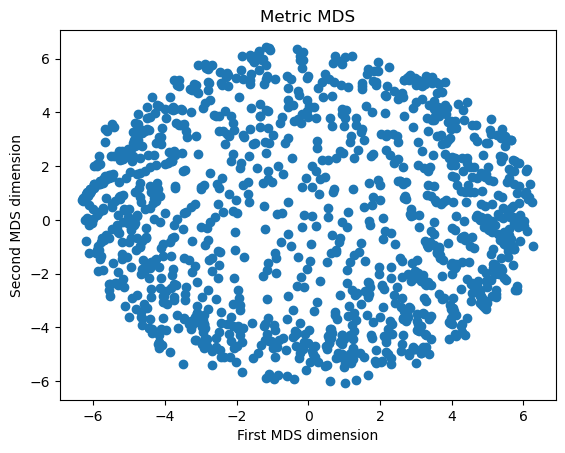

In [182]:
_, ax1 = plt.subplots(1)
scatter1 = ax1.scatter(ballots_transformed[:, 0], ballots_transformed[:, 1])
ax1.set_title(f'Metric MDS')
ax1.set_xlabel('First MDS dimension')
ax1.set_ylabel('Second MDS dimension')
plt.show()

In [183]:
mds_non_metric = MDS(n_components=2, metric=False, random_state=random_state)

In [184]:
ballots_transformed_non_metric = mds_non_metric.fit_transform(ballots_borda)

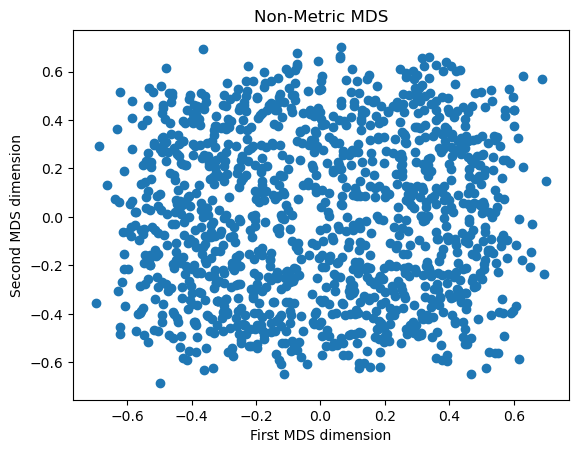

In [185]:
_, ax1 = plt.subplots(1)
scatter1 = ax1.scatter(ballots_transformed_non_metric[:, 0], ballots_transformed_non_metric[:, 1])
ax1.set_title(f'Non-Metric MDS')
ax1.set_xlabel('First MDS dimension')
ax1.set_ylabel('Second MDS dimension')
plt.show()

In [186]:
def extract_centroids(model, z, K, Dims, V):
    """
    Extract centroid coordinates from a solved Gurobi model.
    
    Parameters:
    model : gurobipy.Model
        The solved Gurobi model
    z : dict
        Dictionary of z[i,r,v] binary variables where:
        - i: dimension index
        - r: cluster index
        - v: possible value
    K : list/range
        List of cluster indices
    Dims : list/range
        List of dimension indices
    V : list
        List of possible values for each dimension
        
    Returns:
    centroids : numpy.ndarray
        Array of shape (n_clusters, n_dimensions) containing centroid coordinates
    """
    import numpy as np
    
    # Initialize centroid array
    centroids = np.zeros((len(K), len(Dims)))
    
    # For each cluster and dimension
    for r in K:
        for i in Dims:
            # Find the value v where z[i,r,v] = 1
            for v in V:
                if abs(z[i,r,v].X - 1.0) < 1e-6:  # Check if binary variable is 1 (with tolerance)
                    centroids[r,i] = v
                    break
    
    return centroids

In [201]:
centroids = extract_centroids(model, z, range(3), range(ballots_borda.shape[1]), value_set)

In [202]:
print(centroids)

[[7.  3.5 3.5 3.5 3.5 3.5 3.5]
 [3.5 3.5 7.  3.5 3.5 3.5 3.5]
 [3.5 3.5 3.5 7.  3.5 3.5 3.5]]


In [206]:
def plot_2d_mds(ballots, centroids, weights, metric=True, random_state=1):
    mds = MDS(n_components=2, metric=metric, random_state=random_state)
    combined = np.vstack([ballots, centroids])
    X = mds.fit_transform(combined)
    X_points = X[:len(ballots)]
    X_centroids = X[len(ballots):]
    
    plt.figure(figsize=(10, 8))
    

    plt.scatter(X_points[:, 0], X_points[:, 1], 
               c=weights, cmap='viridis', alpha=0.6, label='Points')
    

    plt.scatter(X_centroids[:, 0], X_centroids[:, 1], 
               c='red', s=200, marker='*', label='Centroids')
    
    plt.title('Metric MDS')
    plt.xlabel('First MDS dimension')
    plt.ylabel('Second MDS dimension')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()    

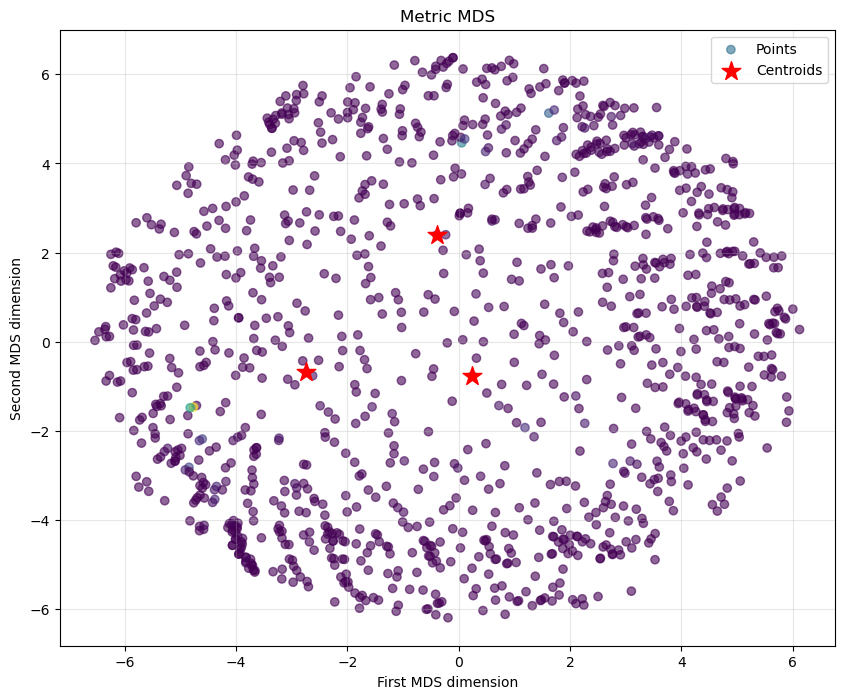

In [208]:
plot_2d_mds(ballots_borda,centroids, sample_weight_borda)

In [210]:
sample_weight_borda

array([494, 131,  23, ...,   1,   1,   1])

In [212]:
from scipy.spatial.distance import cdist
def create_weighted_distance_histogram(original_points, original_centroids, weights, n_bins=20):
    """
    Create a histogram of Euclidean distances weighted by ballot counts.
    
    Parameters:
    original_points : array-like, shape (n_points, n_dimensions)
        The original high-dimensional points
    original_centroids : array-like, shape (n_centroids, n_dimensions)
        The original high-dimensional centroids
    weights : array-like, shape (n_points,)
        The weight (ballot count) for each point
    n_bins : int, optional (default=50)
        Number of bins for the histogram
    """
    # Calculate distances to each centroid
    distances = cdist(original_points, original_centroids, metric='euclidean')
    n_centroids = original_centroids.shape[0]
    
    # Find nearest centroid for each point
    nearest_centroid = np.argmin(distances, axis=1)
    
    # Create subplots
    fig, axes = plt.subplots(n_centroids, 1, figsize=(12, 4*n_centroids))
    if n_centroids == 1:
        axes = [axes]
    
    # Create histogram for each centroid
    for i in range(n_centroids):
        ax = axes[i]
        
        # Get points assigned to this centroid
        mask = (nearest_centroid == i)
        centroid_distances = distances[mask, i]
        centroid_weights = weights[mask]
        
        # Create histogram
        ax.hist(centroid_distances, bins=n_bins, weights=centroid_weights,
               edgecolor='black', alpha=0.7)
        
        ax.set_title(f'Centroid {i} Distance Distribution')
        ax.set_xlabel('Distance to Centroid')
        ax.set_ylabel('Total Ballot Count')
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


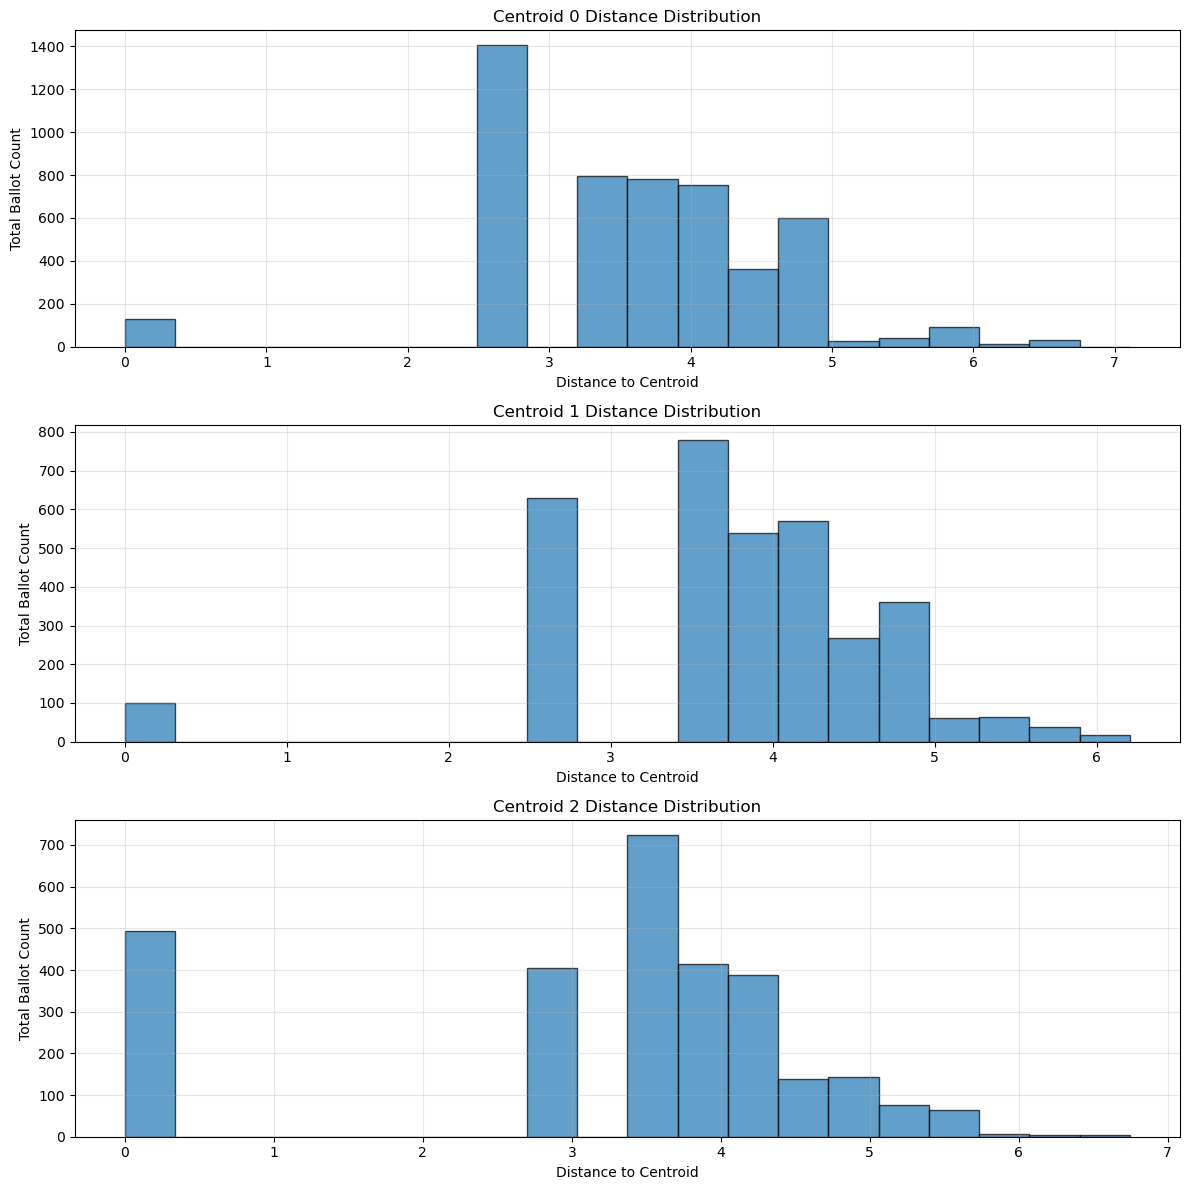

In [214]:
create_weighted_distance_histogram(ballots_borda, centroids, sample_weight_borda)